# Shotgun Analysis of OvCa-Cell Lines EVs

In [1]:
from numba import njit

## Imported Libraries

In [2]:
### Data Handling
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from scipy.stats import pearsonr
pd.options.display.max_columns = None
#pd.options.display.max_rows = None
from itertools import combinations
import re
import Peptide_Chef as Chef
from pyteomics import parser, electrochem
import math

#Statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Figure Generation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import offsetbox
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import axes3d
from IPython.display import Image, display
import seaborn as sns
from adjustText import adjust_text
import glob

#Venn Diagrams
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
%matplotlib inline

cmap = 'PRGn'
fmt='eps'
dpi=600

In [3]:
print('The numpy version is {}.'.format(np.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The matplotlib version is {}.'.format(matplotlib.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The numpy version is 1.19.5.
The pandas version is 1.0.5.
The matplotlib version is 3.2.2.
The seaborn version is 0.11.0.


## Global Lists and Varibles

In [4]:
peanut=['Protein ID','Protein', 'Peptide','Gene','Mass','RT','Score (%)','m/z','z','Length']
rulers=["Mass","RT","m/z","z","Peptide","Length","Hydro_Sum","IPC","Neutral_Z"]
colors = {"TrypLysC":"green","Thermolysin":"purple","Combined":"black"}
lines=["OV90","OV90","OVCAR3","OVCAR3","hIOSE","hIOSE","EOC6","EOC6","EOC18","EOC18"]
enzymes=["Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC",]

In [5]:
def Mass(peptide):
    mass = {  
    "A": 71.037114,
    "R": 156.101111,
    "N": 114.042927,
    "D": 115.026943,
    "C": 103.009185,
    "Q": 129.042593,
    "E": 128.058578,
    "G": 57.021464,
    "H": 137.058912,
    "I": 113.084064,
    "L": 113.084064,
    "K": 128.094963,
    "M": 131.040485,
    "F": 147.068414,
    "P": 97.052764,
    "S": 87.032028,
    "T": 101.047679,
    "W": 186.079313,
    "Y": 163.06332,
    "V": 99.068414,
    }
    mass_list = [mass.get(aa,0.0)for aa in peptide]
    pep_mass=sum(mass_list)
    return pep_mass

## Dataframes

### Missed Clevages

### Summary

In [6]:
scans=pd.DataFrame({"Cell_Line":["OV90","OV90","OVCAR3","OVCAR3","hIOSE","hIOSE","EOC6","EOC6","EOC18","EOC18"],
                    "Enzyme":["Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC"],
                    "MS1":[34878,29335,32978,27523,35687,33242,35907,32591,35079,31145],
                    "MS2":[40703,69406,46278,81008,29237,42700,29241,46428,36466,57219],
                    "Identified_Features":[7897,32123,2697,9173,3540,21690,3982,20044,7232,27737],
                    "Cleavages":[5543,17078,5641,5745,2464,12541,2845,11848,5093,15453],
                    "Missed_0":[499,15978,123,5332,182,11829,261,11233,444,14562],
                    "Missed_1":[1494,1050,4447,399,707,693,833,605,1461,866],
                    "Missed_2":[1747,42,601,14,814,17,921,10,1631,25],
                    "Missed_3":[1183,3,470,0,534,2,572,0,1043,0],
                    "Missed_4+":[620,5,238,0,227,0,258,0,514,0]
    
})
markers={"OV90":"o","OVCAR3":"s","hIOSE":"+","EOC6":"*","EOC18":"x"}
scans

,Cell_Line,Enzyme,MS1,MS2,Identified_Features,Cleavages,Missed_0,Missed_1,Missed_2,Missed_3,Missed_4+
0,OV90,Thermolysin,34878,40703,7897,5543,499,1494,1747,1183,620
1,OV90,TrypLysC,29335,69406,32123,17078,15978,1050,42,3,5
2,OVCAR3,Thermolysin,32978,46278,2697,5641,123,4447,601,470,238
3,OVCAR3,TrypLysC,27523,81008,9173,5745,5332,399,14,0,0
4,hIOSE,Thermolysin,35687,29237,3540,2464,182,707,814,534,227
5,hIOSE,TrypLysC,33242,42700,21690,12541,11829,693,17,2,0
6,EOC6,Thermolysin,35907,29241,3982,2845,261,833,921,572,258
7,EOC6,TrypLysC,32591,46428,20044,11848,11233,605,10,0,0
8,EOC18,Thermolysin,35079,36466,7232,5093,444,1461,1631,1043,514
9,EOC18,TrypLysC,31145,57219,27737,15453,14562,866,25,0,0


In [7]:
labels=["0","1","2","3","4+"]
columns=["Missed_0","Missed_1","Missed_2","Missed_3","Missed_4+"]

for label,column in zip(labels,columns):
    scans[label]=(scans[column]/scans.Cleavages)*100

scans

,Cell_Line,Enzyme,MS1,MS2,Identified_Features,Cleavages,Missed_0,Missed_1,Missed_2,Missed_3,Missed_4+,0,1,2,3,4+
0,OV90,Thermolysin,34878,40703,7897,5543,499,1494,1747,1183,620,9.002345,26.952914,31.517229,21.342233,11.185279
1,OV90,TrypLysC,29335,69406,32123,17078,15978,1050,42,3,5,93.558965,6.148261,0.245930,0.017566,0.029277
2,OVCAR3,Thermolysin,32978,46278,2697,5641,123,4447,601,470,238,2.180464,78.833540,10.654139,8.331856,4.219110
3,OVCAR3,TrypLysC,27523,81008,9173,5745,5332,399,14,0,0,92.811140,6.945170,0.243690,0.000000,0.000000
4,hIOSE,Thermolysin,35687,29237,3540,2464,182,707,814,534,227,7.386364,28.693182,33.035714,21.672078,9.212662
5,hIOSE,TrypLysC,33242,42700,21690,12541,11829,693,17,2,0,94.322622,5.525875,0.135555,0.015948,0.000000
6,EOC6,Thermolysin,35907,29241,3982,2845,261,833,921,572,258,9.173989,29.279438,32.372583,20.105448,9.068541
7,EOC6,TrypLysC,32591,46428,20044,11848,11233,605,10,0,0,94.809251,5.106347,0.084402,0.000000,0.000000
8,EOC18,Thermolysin,35079,36466,7232,5093,444,1461,1631,1043,514,8.717848,28.686432,32.024347,20.479089,10.092284
9,EOC18,TrypLysC,31145,57219,27737,15453,14562,866,25,0,0,94.234129,5.604090,0.161781,0.000000,0.000000


<ipython-input-8-c123c4ccabe1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Missed'] = temp2
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


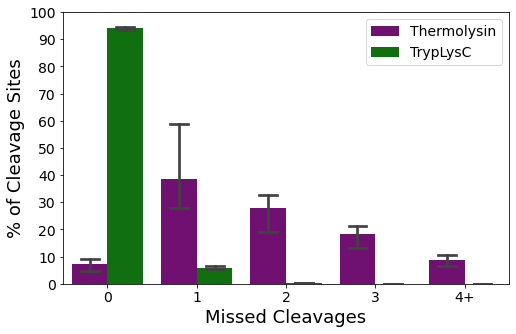

In [8]:

scans["Cells"]=["OV90","OV90","OVCAR3","OVCAR3","hIOSE","hIOSE","EOC6","EOC6","EOC18","EOC18"]
scans["Enzyme"]=["Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC"]

cleavages=pd.DataFrame()
temp_list=[]

for label in labels:
    temp=str("df_"+label)
    temp2=str(label)
    temp=scans[["Cell_Line","Enzyme",label]]
    temp.columns=["Cells","Enzyme","Value"]
    temp['Missed'] = temp2
    temp_list.append(temp)
cleavages=pd.concat(temp_list,ignore_index=False)


plt.figure(figsize=(8,5))
sns.barplot(x="Missed", y="Value", hue="Enzyme", data=cleavages, palette=colors,capsize=0.2)
plt.xticks(fontsize=14)
plt.xlabel("Missed Cleavages",fontsize=18)
plt.yticks(np.arange(0,101,10),fontsize=14)
plt.ylabel("% of Cleavage Sites",fontsize=18)
plt.legend(fontsize=14)
plt.savefig("Cleavage Sites.eps",dpi=1200,bbox_inches='tight')  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


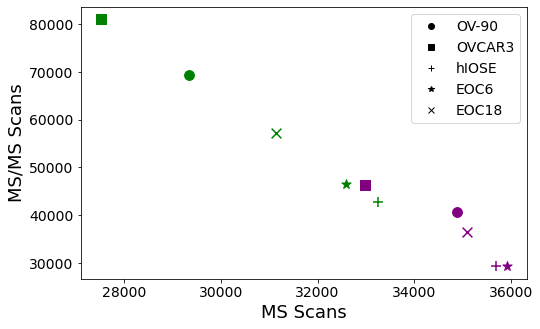

In [9]:
nums=np.arange(0,len(scans))

plt.figure(figsize=(8,5))
for line,enzyme,num in zip(lines,enzymes,nums):
      plt.scatter(scans.MS1[num],scans.MS2[num],color=colors[enzyme],marker=markers[line], s=96)
plt.xticks(fontsize=14)
plt.xlabel("MS Scans",fontsize=18)
plt.yticks(fontsize=14)
plt.ylabel("MS/MS Scans",fontsize=18)

ov90=plt.Line2D([0,0],[0,0], color='black', marker='o', linestyle='')
ovcar3=plt.Line2D([0,0],[0,0], color='black', marker='s', linestyle='')
hiose=plt.Line2D([0,0],[0,0], color='black', marker='+', linestyle='')
eoc6=plt.Line2D([0,0],[0,0], color='black', marker='*', linestyle='')
eoc18=plt.Line2D([0,0],[0,0], color='black', marker='x', linestyle='')

plt.legend([ov90,ovcar3,hiose,eoc6,eoc18],["OV-90","OVCAR3","hIOSE","EOC6","EOC18"],fontsize=14)
plt.savefig("MS1vsMS2.eps",dpi=1200,bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


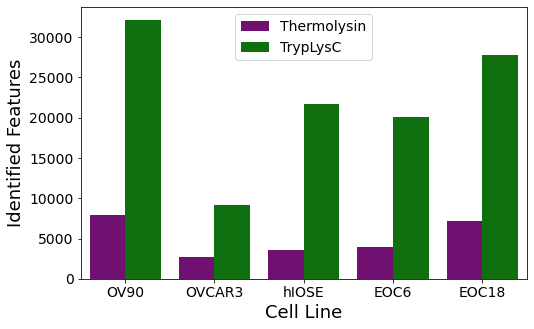

In [10]:
plt.figure(figsize=(8,5))
sns.barplot(x="Cell_Line", y="Identified_Features", hue="Enzyme",palette=colors,
                 data=scans, dodge=True)
plt.ylabel("Identified Features",fontsize=18)
plt.xlabel("Cell Line",fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig("identified_features.eps",dpi=1200)

### RAW PEAKS

In [11]:
raw=Chef.PEAKS_Importer("protein-peptides.csv")
raw = raw[raw['Peptide'].notna()]
# rawz =raw.groupby(by="Protein").size()
# raws=rawz['Protein']
# print(raws)
# # %store raws
raw

,Protein Group,Protein ID,Peptide,Unique,Score (%),-10lgP,Mass,Length,ppm,m/z,z,RT,Area OV90_Thermolysin,Area OV90_TrypLysC,Area OVCAR3_Thermolysin,Area OVAR3_TrypLysC,Area hIOSE_Thermolysin,Area hIOSE_TrypLysC,Area EOC18_Thermolysin,Area EOC18_TrypLysC,Area EOC6_Thermolysin,Area EOC6_TrypLysC,Fraction,Scan,Source File,#Feature,#Feature OV90_Thermolysin,#Feature OV90_TrypLysC,#Feature OVCAR3_Thermolysin,#Feature OVAR3_TrypLysC,#Feature hIOSE_Thermolysin,#Feature hIOSE_TrypLysC,#Feature EOC18_Thermolysin,#Feature EOC18_TrypLysC,#Feature EOC6_Thermolysin,#Feature EOC6_TrypLysC,Start,End,PTM,AScore,Protein,Gene,Species
0,1,11,K.C(+57.02)DPVDQC(+57.02)QDSETGTFYQIGDSWEK.Y,Y,100.0,127.55,2864.1541,24,0.1,1433.0845,2,43.75,NaN,1.114400e+08,NaN,NaN,NaN,31101000.0,NaN,99779000.0,NaN,14003000.0,29,F29:19065,TC_26April2021_EOC18_TrypLysC_90min_rep2.raw,13,0,4,0,0,0,2,0,5,0,2,555,578,Carbamidomethylation,C1:Carbamidomethylation:1000.00;C7:Carbamidome...,P02751,FINC,HUMAN
1,1,11,K.TETITGFQVDAVPANGQTPIQR.T,Y,99.9,101.67,2342.1865,22,0.9,1172.1016,2,41.26,NaN,2.499200e+08,NaN,NaN,NaN,36004000.0,NaN,209940000.0,NaN,201230000.0,25,F25:16918,TC_30April2021_hIOSE_TrypLysC_90min_rep2.raw,15,0,4,0,0,0,4,0,5,0,2,1929,1950,NaN,NaN,P02751,FINC,HUMAN
2,1,11,K.FTQVTPTSLSAQWTPPNVQLTGYR.V,Y,99.9,98.72,2691.3657,24,0.7,1346.6910,2,46.27,NaN,1.561600e+09,NaN,NaN,NaN,80732000.0,NaN,583170000.0,NaN,231230000.0,29,F29:20634,TC_26April2021_EOC18_TrypLysC_90min_rep2.raw,19,0,8,0,0,0,3,0,4,0,4,1821,1844,NaN,NaN,P02751,FINC,HUMAN
3,1,11,K.GLKPGVVYEGQLISIQQYGHQEVTR.F,Y,99.9,97.55,2798.4714,25,2.1,933.8330,3,40.87,NaN,2.580800e+09,NaN,0.0,NaN,16260000.0,NaN,281760000.0,NaN,100570000.0,17,F17:17781,TC_02May2021_OV90_TrypLysC_90min_rep2.raw,15,0,6,0,0,0,2,0,4,0,3,670,694,NaN,NaN,P02751,FINC,HUMAN
4,1,11,R.HTSVQTTSSGSGPFTDVR.A,Y,99.9,96.75,1862.8759,18,-0.1,621.9658,3,27.84,NaN,2.177100e+09,NaN,NaN,NaN,181530000.0,NaN,479830000.0,NaN,263060000.0,25,F25:8698,TC_30April2021_hIOSE_TrypLysC_90min_rep2.raw,16,0,5,0,0,0,3,0,4,0,4,273,290,NaN,NaN,P02751,FINC,HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43894,4247,5739,R.LPDDC(+57.02)TIGYIVEALLGVPLIR.S,Y,51.0,23.84,2326.2605,21,0.7,776.4280,3,63.94,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4,F4:30615,TC_24April2021_OVCAR3_TrypLysC_90min.raw,0,0,0,0,0,0,0,0,0,0,0,287,307,Carbamidomethylation,C5:Carbamidomethylation:1000.00,Q8NES3,LFNG,HUMAN
43895,3851,6618,R.EYLDYDDTR.Y,Y,88.8,23.83,1188.4934,9,3.0,595.2557,2,28.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1194300.0,33,F33:9802,TC_29April2021_EOC6_TrypLysC_90min_rep2.raw,1,0,0,0,0,0,0,0,0,0,1,173,181,NaN,NaN,Q9BVI4,NOC4L,HUMAN
43896,3733,6508,K.LGEEQQR.Q,Y,56.2,23.82,858.4195,7,4.8,430.2191,2,23.50,NaN,NaN,NaN,507730.0,NaN,NaN,NaN,NaN,NaN,NaN,21,F21:4721,TC_01May2021_OVCAR3_TrypLysC_90min_rep2.raw,1,0,0,0,1,0,0,0,0,0,0,560,566,NaN,NaN,Q9H1B7,I2BPL,HUMAN
43897,4002,53428,K.LQQAQEMLK.E,Y,90.3,23.82,1087.5696,9,1.2,544.7927,2,26.67,NaN,5.394500e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,F17:8879,TC_02May2021_OV90_TrypLysC_90min_rep2.raw,1,0,1,0,0,0,0,0,0,0,0,341,349,NaN,NaN,P40222,TXLNA,HUMAN


In [12]:
def Butcher(df,ident1=None,ident2=None,ident3=None,t_id=None,t_value=0,acid=["J","Z"],labels=list(),excel_mapper=True,excel_name=None):
    tag=df[labels]
    raw= df.filter(like=str(ident1), axis=1)
    raw = pd.concat([raw, tag], axis=1)
    cuts = raw.filter(like=str(ident2), axis=1)
    cuts = pd.concat([cuts,tag], axis=1)
    #Clean Peptides, Removing Numbers and Symbols, removing first amino acid if enzyme cleaves at C-terminal
    cuts["Peptide"]= cuts["Peptide"].str.replace('\W+|\d+',"")
    cuts["Peptide"]= cuts["Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)
    cuts=cuts.fillna(0)
    blade=cuts.filter(regex=t_id, axis='columns')
    trim=blade==t_value
    trimmings=trim.all(axis=1)
    cuts=cuts.loc[~trimmings,:]
    cuts.reset_index(inplace=True)
    cuts.drop('index', axis=1, inplace=True)
#     excels=[raw,cuts]
#     Excel_Mapper(excels,excel_name +".xlsx")
    return raw, cuts, blade

In [13]:
# OV90_Thermolysin
x="OV90"
y="Thermolysin"
acid=["F","M","V","A","I","L"]
excel_name="OV90_Thermolsyin"
Thermolysin, OV90_Thermolysin,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=["F","M","V","A","I","L"],labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(OV90_Thermolysin,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area OV90_Thermolysin,#Feature OV90_Thermolysin,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,1.896200e+09,4,11,P02751,AVYQPQPHPQPPPYGHCV,FINC,1971.9049,27.21,99.9,986.9594,2,17,7.292646,-0.933333,0.0
1,3.550400e+08,4,11,P02751,KIGEKWDRQGENGQMM,FINC,1662.7419,20.85,99.9,832.3776,2,14,7.087842,-1.693750,0.0
2,7.654100e+08,5,11,P02751,RVGDTYERPKDSMI,FINC,1396.6293,21.01,99.9,699.3220,2,12,6.985439,-1.257143,0.0
3,5.145500e+08,4,11,P02751,KIGEKWDRQGENGQMM,FINC,1646.7471,25.29,99.9,824.3792,2,14,7.087842,-1.693750,0.0
4,9.909600e+07,4,11,P02751,RIGDQWDKQHDMGHMM,FINC,1696.7086,28.04,99.9,849.3621,2,14,6.033193,-1.487500,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159,2.398800e+05,1,3231,O94854,DIFEEREQANTA,K0754,1235.5782,22.64,91.6,618.7960,2,10,3.744521,-1.275000,-3.0
6160,4.165000e+05,1,4199,P42658,VVDGTPGSQSV,DPP6,945.4403,26.41,92.2,473.7353,2,10,3.134209,0.081818,-1.0
6161,2.968800e+06,1,4361,Q6YP21,IILNTPHNPL,KAT3,1017.5607,29.66,92.2,509.7874,2,9,7.790029,0.250000,0.0
6162,7.640400e+05,1,4246,Q9NR71,NLSRGPEPPFF,ASAH2,998.5185,33.99,92.2,500.2682,2,9,6.941553,-0.736364,0.0


### OV90_Thermolysin

In [14]:
# OV90_Trypsin
x="OV90"
y="TrypLysC"
acid=["K","R"]
excel_name="OV90_Trypsin"
Thermolysin, OV90_TrypLysC,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(OV90_TrypLysC,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area OV90_TrypLysC,#Feature OV90_TrypLysC,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,1.114400e+08,4,11,P02751,CDPVDQCQDSETGTFYQIGDSWEKY,FINC,2864.1541,43.75,100.0,1433.0845,2,24,3.350361,-1.112000,-5.0
1,2.499200e+08,4,11,P02751,TETITGFQVDAVPANGQTPIQRT,FINC,2342.1865,41.26,99.9,1172.1016,2,22,4.113252,-0.400000,-1.0
2,1.561600e+09,8,11,P02751,FTQVTPTSLSAQWTPPNVQLTGYRV,FINC,2691.3657,46.27,99.9,1346.6910,2,24,9.808818,-0.248000,1.0
3,2.580800e+09,6,11,P02751,GLKPGVVYEGQLISIQQYGHQEVTRF,FINC,2798.4714,40.87,99.9,933.8330,3,25,7.672998,-0.303846,0.0
4,2.177100e+09,5,11,P02751,HTSVQTTSSGSGPFTDVRA,FINC,1862.8759,27.84,99.9,621.9658,3,18,7.790029,-0.531579,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17701,8.999400e+06,1,4058,Q8NGA1,ILVAIMKV,OR1M1,786.5037,39.91,90.7,787.5112,1,7,10.042881,2.625000,1.0
17702,2.601800e+06,1,4403,Q9Y3C8,VVSEIPVLKT,UFC1,982.6063,37.08,91.8,492.3094,2,9,6.926924,1.040000,0.0
17703,5.485400e+06,1,4458,P49790,EGSVLDILKS,NU153,972.5491,44.12,91.6,487.2772,2,9,4.113252,0.340000,-1.0
17704,5.024500e+07,1,4367,Q7Z6K1,ITLLELKE,THAP5,828.5320,42.58,90.5,415.2733,2,7,4.329404,0.537500,-1.0


In [15]:
chicken,pot, pie = Chef.Wishbone(OV90_Thermolysin, "Protein",split=1)

The number of proteins with > 1 peptides : 854.0
Ratio of Proteins with > 1 Peptides Identified: 59.512


### OV90_TrypLysC

In [16]:
# OV90_Trypsin
x="TrypLysC"
y="OV90"
acid=["K","R"]
excel_name="OV90_Trypsin"
TrypLysC_raw, OV90_TrypLysC,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(OV90_TrypLysC,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area OV90_TrypLysC,#Feature OV90_TrypLysC,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,1.114400e+08,4,11,P02751,CDPVDQCQDSETGTFYQIGDSWEKY,FINC,2864.1541,43.75,100.0,1433.0845,2,24,3.350361,-1.112000,-5.0
1,2.499200e+08,4,11,P02751,TETITGFQVDAVPANGQTPIQRT,FINC,2342.1865,41.26,99.9,1172.1016,2,22,4.113252,-0.400000,-1.0
2,1.561600e+09,8,11,P02751,FTQVTPTSLSAQWTPPNVQLTGYRV,FINC,2691.3657,46.27,99.9,1346.6910,2,24,9.808818,-0.248000,1.0
3,2.580800e+09,6,11,P02751,GLKPGVVYEGQLISIQQYGHQEVTRF,FINC,2798.4714,40.87,99.9,933.8330,3,25,7.672998,-0.303846,0.0
4,2.177100e+09,5,11,P02751,HTSVQTTSSGSGPFTDVRA,FINC,1862.8759,27.84,99.9,621.9658,3,18,7.790029,-0.531579,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17701,8.999400e+06,1,4058,Q8NGA1,ILVAIMKV,OR1M1,786.5037,39.91,90.7,787.5112,1,7,10.042881,2.625000,1.0
17702,2.601800e+06,1,4403,Q9Y3C8,VVSEIPVLKT,UFC1,982.6063,37.08,91.8,492.3094,2,9,6.926924,1.040000,0.0
17703,5.485400e+06,1,4458,P49790,EGSVLDILKS,NU153,972.5491,44.12,91.6,487.2772,2,9,4.113252,0.340000,-1.0
17704,5.024500e+07,1,4367,Q7Z6K1,ITLLELKE,THAP5,828.5320,42.58,90.5,415.2733,2,7,4.329404,0.537500,-1.0


In [17]:
chicken,pot, pie = Chef.Wishbone(OV90_TrypLysC, "Gene",split=1)

The number of proteins with > 1 peptides : 1860.0
Ratio of Proteins with > 1 Peptides Identified: 72.430


### OVCAR3_Thermolysin

In [18]:
# OV90_Thermolysin
x="OVCAR3"
y="Thermolysin"
acid=["F","M","V","A","I","L"]
excel_name="OVCAR3_Thermolysin"
Thermolysin, OVCAR3_Thermolysin,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(OVCAR3_Thermolysin,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area OVCAR3_Thermolysin,#Feature OVCAR3_Thermolysin,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,104380000.0,4,11,P02751,RVGDTYERPKDSMI,FINC,1396.6293,21.01,99.9,699.3220,2,12,6.985439,-1.257143,0.0
1,41316000.0,2,11,P02751,KIGEKWDRQGENGQMM,FINC,1646.7471,25.29,99.9,824.3792,2,14,7.087842,-1.693750,0.0
2,37958000.0,6,11,P02751,RIGDQWDKQHDMGHMM,FINC,1696.7086,28.04,99.9,849.3621,2,14,6.033193,-1.487500,-1.0
3,22123000.0,2,11,P02751,YVVGETWEKPYQGWM,FINC,1577.7515,42.59,99.9,789.8818,2,13,4.329404,-0.773333,-1.0
4,2997900.0,2,11,P02751,YVVGETWEKPYQGWMM,FINC,1724.7869,41.20,99.9,863.4010,2,14,4.329404,-0.606250,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,9634400.0,1,4427,A6NEM1,ARPVAGAPVPQGA,GG6L9,1119.6036,34.80,82.2,560.8030,2,12,11.037646,0.153846,1.0
2195,12247000.0,1,5767,Q9HAP2,LNPPAPPTF,MLXIP,806.4174,26.32,79.2,404.2171,2,8,5.969619,-0.244444,0.0
2196,106130000.0,1,4987,P25067,GVDGVGVPGAAGL,CO8A2,897.4556,27.14,80.9,449.7263,2,11,3.134209,0.992308,-1.0
2197,2659800.0,1,4829,Q96K62,PLPTPVPPPL,ZBT45,816.4745,50.71,80.6,409.2442,2,8,5.969619,0.150000,0.0


In [19]:
chicken,pot, pie = Chef.Wishbone(OVCAR3_Thermolysin, "Protein",split=1)

The number of proteins with > 1 peptides : 352.0
Ratio of Proteins with > 1 Peptides Identified: 48.957


### OVCAR3_TrypLysC

In [20]:
# OVCAR3_Trypsin
x="OVAR3"
y="TrypLysC"
acid=["K","R"]
excel_name="OVCAR3_Trypsin"
TrypLysC_pep, OVCAR3_TrypLysC,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(OVCAR3_TrypLysC,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area OVAR3_TrypLysC,#Feature OVAR3_TrypLysC,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,43247000.0,2,11,P02751,VPGTSTSATLTGLTRG,FINC,1460.7834,33.97,99.9,731.3987,2,15,11.037646,0.075000,1.0
1,28618000.0,2,11,P02751,FGFCPMAAHEEICTTNEGVMYRI,FINC,2619.1016,42.51,99.9,1310.5576,2,22,4.596416,0.191304,-2.0
2,3400700.0,1,11,P02751,QGENGQMMSCTCLGNGKG,FINC,1872.7111,29.10,99.9,937.3629,2,17,6.147627,-0.683333,0.0
3,29561000.0,3,11,P02751,VTWAPPPSIDLTNFLVRY,FINC,1925.0410,51.95,99.9,642.6889,3,17,6.678232,0.244444,0.0
4,5353400.0,1,11,P02751,NTFAEVTGLSPGVTYYFKV,FINC,1992.9833,47.27,99.9,997.4996,2,18,6.824521,0.263158,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6070,323980.0,1,12717,Q9NQT8,SLFPVRDEKR,KI13B,1089.5818,41.87,60.7,545.7906,2,9,10.028252,-1.150000,1.0
6071,34634000.0,1,4367,Q7Z6K1,ITLLELKE,THAP5,828.5320,42.58,90.5,415.2733,2,7,4.329404,0.537500,-1.0
6072,17713000.0,1,3030,Q14562,NPDGSLSQAAMMQSALAKERR,DHX8,2121.9670,43.16,51.9,1061.9957,2,20,10.028252,-0.771429,1.0
6073,26442000.0,1,2175,O75445,ACTVAGCATSSKV,USH2A,1211.5275,25.72,51.1,606.7814,2,12,8.258154,0.884615,1.0


In [21]:
chicken,pot, pie = Chef.Wishbone(OVCAR3_TrypLysC, "Protein",split=1)

The number of proteins with > 1 peptides : 819.0
Ratio of Proteins with > 1 Peptides Identified: 62.424


### hIOSE_Thermolysin

In [22]:
# hIOSE_Thermolysin
x="hIOSE"
y="Thermolysin"
acid=["F","M","V","A","I","L"]
excel_name="hIOSE_Thermolysin"
Thermolysin, hIOSE_Thermolysin,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(hIOSE_Thermolysin,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area hIOSE_Thermolysin,#Feature hIOSE_Thermolysin,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,1882800.0,1,11,P02751,RVGDTYERPKDSMI,FINC,1396.6293,21.01,99.9,699.3220,2,12,6.985439,-1.257143,0.0
1,2605700.0,2,11,P02751,YVVGETWEKPYQGWM,FINC,1577.7515,42.59,99.9,789.8818,2,13,4.329404,-0.773333,-1.0
2,31340000.0,3,11,P02751,TVKDDKESVPISDTI,FINC,1431.7092,22.18,99.9,716.8616,2,13,3.998818,-0.600000,-2.0
3,34955000.0,2,11,P02751,SVQTTSSGSGPFTDVRAA,FINC,1608.7743,33.53,99.9,805.3948,2,16,6.736748,-0.244444,0.0
4,1128400.0,2,11,P02751,SLEEVVHADQSSCTF,FINC,1473.6405,24.33,99.9,737.8271,2,13,3.871670,-0.066667,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,6059900.0,1,3601,Q96DB9,GFHEDDPFF,FXYD5,905.3555,34.78,93.5,453.6847,2,7,3.731807,-0.811111,-3.0
2918,74092.0,1,3935,Q7Z5P9,TAPGPPTTVTA,MUC19,839.4388,45.40,90.6,420.7345,2,9,5.969619,-0.018182,0.0
2919,84490.0,1,16701,Q13363,NVLFYDPYL,CTBP1,915.4378,45.51,88.7,916.4471,1,7,3.134209,0.377778,-1.0
2920,84490.0,1,53318,P56545,SVIFYDPYL,CTBP2,915.4378,45.51,88.7,916.4471,1,7,3.134209,0.755556,-1.0


In [23]:
chicken,pot, pie = Chef.Wishbone(hIOSE_Thermolysin, "Protein",split=1)

The number of proteins with > 1 peptides : 447.0
Ratio of Proteins with > 1 Peptides Identified: 53.088


### hIOSE_TrypLysC

In [24]:
# hIOSE_TrypLysC
x="hIOSE"
y="TrypLysC"
acid=["K","R"]
excel_name="hIOSE_TrypLysC"
Thermolysin, hIOSE_TrypLysC,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(hIOSE_TrypLysC,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area hIOSE_TrypLysC,#Feature hIOSE_TrypLysC,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,31101000.0,2,11,P02751,CDPVDQCQDSETGTFYQIGDSWEKY,FINC,2864.1541,43.75,100.0,1433.0845,2,24,3.350361,-1.112000,-5.0
1,36004000.0,4,11,P02751,TETITGFQVDAVPANGQTPIQRT,FINC,2342.1865,41.26,99.9,1172.1016,2,22,4.113252,-0.400000,-1.0
2,80732000.0,3,11,P02751,FTQVTPTSLSAQWTPPNVQLTGYRV,FINC,2691.3657,46.27,99.9,1346.6910,2,24,9.808818,-0.248000,1.0
3,16260000.0,2,11,P02751,GLKPGVVYEGQLISIQQYGHQEVTRF,FINC,2798.4714,40.87,99.9,933.8330,3,25,7.672998,-0.303846,0.0
4,181530000.0,3,11,P02751,HTSVQTTSSGSGPFTDVRA,FINC,1862.8759,27.84,99.9,621.9658,3,18,7.790029,-0.531579,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13392,46889.0,1,7084,P54259,GGGAASSVGGPNGGKQ,ATN1,1172.5421,19.34,93.4,587.2727,2,15,10.042881,-0.568750,1.0
13393,132220.0,1,17718,Q8TB05,MSVNMDELKH,UBAD1,1097.4733,28.51,92.8,549.7466,2,9,5.257588,-0.660000,-1.0
13394,1972400.0,1,13211,Q99466,DQAGLAPADVAHQRN,NOTC4,1448.7008,26.68,92.4,725.3513,2,14,5.117725,-0.800000,-1.0
13395,159230.0,1,5085,Q9Y520,SSSQIPAQPSVAKV,PRC2C,1298.6830,23.17,92.2,650.3486,2,13,10.042881,-0.057143,1.0


In [25]:
chicken,pot, pie = Chef.Wishbone(hIOSE_TrypLysC, "Protein",split=1)

The number of proteins with > 1 peptides : 1582.0
Ratio of Proteins with > 1 Peptides Identified: 70.374


### EOC6_Thermolysin

In [26]:
# EOC6_Thermolysin
x="EOC6"
y="Thermolysin"
acid=["F","M","V","A","I","L"]
excel_name="EOC6_Thermolysin"
Thermolysin, EOC6_Thermolysin,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(EOC6_Thermolysin,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area EOC6_Thermolysin,#Feature EOC6_Thermolysin,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,258580000.0,3,11,P02751,AVYQPQPHPQPPPYGHCV,FINC,1971.9049,27.21,99.9,986.9594,2,17,7.292646,-0.933333,0.0
1,4511300.0,1,11,P02751,KIGEKWDRQGENGQMM,FINC,1662.7419,20.85,99.9,832.3776,2,14,7.087842,-1.693750,0.0
2,108030000.0,3,11,P02751,RVGDTYERPKDSMI,FINC,1396.6293,21.01,99.9,699.3220,2,12,6.985439,-1.257143,0.0
3,46789000.0,4,11,P02751,KIGEKWDRQGENGQMM,FINC,1646.7471,25.29,99.9,824.3792,2,14,7.087842,-1.693750,0.0
4,3570500.0,1,11,P02751,RIGDQWDKQHDMGHMM,FINC,1696.7086,28.04,99.9,849.3621,2,14,6.033193,-1.487500,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5744,609290.0,1,17072,Q96PU8,ITVEDAQNRAEI,QKI,1244.5996,23.11,91.8,623.3062,2,11,3.884385,-0.491667,-2.0
5745,201470.0,1,15957,Q96CV9,EIETQTEGSTEKENDEEKGPETV,OPTN,2350.0295,18.14,92.9,784.3499,3,21,3.731807,-1.895652,-7.0
5746,1855500.0,1,3912,Q15678,ELIPTKENNTGYI,PTN14,1248.6350,25.02,92.0,625.3262,2,11,4.329404,-0.753846,-1.0
5747,6824000.0,1,7651,O14525,EVLLDSFGPV,ASTN1,846.4487,45.37,92.0,847.4557,1,8,3.045205,0.900000,-2.0


In [27]:
chicken,pot, pie = Chef.Wishbone(EOC6_Thermolysin, "Protein",split=1)

The number of proteins with > 1 peptides : 788.0
Ratio of Proteins with > 1 Peptides Identified: 59.697


### EOC6_TrypLysC

In [28]:
# EOC6_TrypLysC
x="EOC6"
y="TrypLysC"
acid=["K","R"]
excel_name="EOC6_TrypLysC"
TrypLysC_Raw, EOC6_TrypLysC,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(EOC6_TrypLysC,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area EOC6_TrypLysC,#Feature EOC6_TrypLysC,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,14003000.0,2,11,P02751,CDPVDQCQDSETGTFYQIGDSWEKY,FINC,2864.1541,43.75,100.0,1433.0845,2,24,3.350361,-1.112000,-5.0
1,201230000.0,2,11,P02751,TETITGFQVDAVPANGQTPIQRT,FINC,2342.1865,41.26,99.9,1172.1016,2,22,4.113252,-0.400000,-1.0
2,231230000.0,4,11,P02751,FTQVTPTSLSAQWTPPNVQLTGYRV,FINC,2691.3657,46.27,99.9,1346.6910,2,24,9.808818,-0.248000,1.0
3,100570000.0,3,11,P02751,GLKPGVVYEGQLISIQQYGHQEVTRF,FINC,2798.4714,40.87,99.9,933.8330,3,25,7.672998,-0.303846,0.0
4,263060000.0,4,11,P02751,HTSVQTTSSGSGPFTDVRA,FINC,1862.8759,27.84,99.9,621.9658,3,18,7.790029,-0.531579,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16121,94594.0,1,8282,Q9UJX6,MPVALLRR,ANC2,798.4786,37.90,90.3,400.2465,2,7,12.500537,0.612500,2.0
16122,3078500.0,1,12666,O95447,MSLADLTKT,LCA5L,877.4579,37.09,90.1,439.7418,2,8,6.707490,0.188889,0.0
16123,433850.0,1,16909,Q9HCS7,AIEVLSDEHARE,SYF1,1238.6255,27.12,90.1,413.8812,3,11,4.214971,-0.533333,-3.0
16124,1194300.0,1,6618,Q9BVI4,EYLDYDDTRY,NOC4L,1188.4934,28.88,88.8,595.2557,2,9,3.541084,-1.930000,-3.0


In [29]:
chicken,pot, pie = Chef.Wishbone(EOC6_TrypLysC, "Protein",split=1)

The number of proteins with > 1 peptides : 1684.0
Ratio of Proteins with > 1 Peptides Identified: 70.167


### EOC18_Thermolysin

In [30]:
# EOC18_Thermolysin
x="EOC18"
y="Thermolysin"
acid=["F","M","V","A","I","L"]
excel_name="EOC18_Thermolysin"
EOC18, EOC18_Thermolysin,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(EOC18_Thermolysin,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area EOC18_Thermolysin,#Feature EOC18_Thermolysin,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,88494000.0,3,11,P02751,AVYQPQPHPQPPPYGHCV,FINC,1971.9049,27.21,99.9,986.9594,2,17,7.292646,-0.933333,0.0
1,44219000.0,2,11,P02751,KIGEKWDRQGENGQMM,FINC,1662.7419,20.85,99.9,832.3776,2,14,7.087842,-1.693750,0.0
2,283950000.0,4,11,P02751,RVGDTYERPKDSMI,FINC,1396.6293,21.01,99.9,699.3220,2,12,6.985439,-1.257143,0.0
3,68486000.0,4,11,P02751,KIGEKWDRQGENGQMM,FINC,1646.7471,25.29,99.9,824.3792,2,14,7.087842,-1.693750,0.0
4,1026500.0,1,11,P02751,RIGDQWDKQHDMGHMM,FINC,1696.7086,28.04,99.9,849.3621,2,14,6.033193,-1.487500,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362,10790000.0,2,3772,P11226,GITDEKTEGQFV,MBL2,1166.5455,25.28,92.9,584.2798,2,10,3.884385,-0.716667,-2.0
3363,572870.0,1,5667,Q9Y613,PARAPEPGPTGPA,FHOD1,1048.5302,48.64,90.2,525.2684,2,11,6.941553,-0.930769,0.0
3364,2153700.0,1,17183,A8MQ03,LQPTEVPGPKGA,CRTP1,1121.6080,25.24,92.7,561.8101,2,11,6.926924,-0.616667,0.0
3365,40703.0,1,10980,Q86T26,EADACQNDSGGPL,TM11B,1092.3666,17.90,89.7,547.1958,2,11,2.905342,-0.830769,-3.0


In [31]:
chicken,pot,pie = Chef.Wishbone(EOC18_Thermolysin, "Protein",split=1)

The number of proteins with > 1 peptides : 521.0
Ratio of Proteins with > 1 Peptides Identified: 57.065


### EOC18_TrypLysC

In [32]:
# EOC18_TrypLysC
x="EOC18"
y="TrypLysC"
acid=["K","R"]
excel_name="EOC18_TrypLysC"
EOC18, EOC18_TrypLysC,blade=Butcher(raw,ident1=x,ident2=y,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(EOC18_TrypLysC,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area EOC18_TrypLysC,#Feature EOC18_TrypLysC,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,99779000.0,5,11,P02751,CDPVDQCQDSETGTFYQIGDSWEKY,FINC,2864.1541,43.75,100.0,1433.0845,2,24,3.350361,-1.112000,-5.0
1,209940000.0,5,11,P02751,TETITGFQVDAVPANGQTPIQRT,FINC,2342.1865,41.26,99.9,1172.1016,2,22,4.113252,-0.400000,-1.0
2,583170000.0,4,11,P02751,FTQVTPTSLSAQWTPPNVQLTGYRV,FINC,2691.3657,46.27,99.9,1346.6910,2,24,9.808818,-0.248000,1.0
3,281760000.0,4,11,P02751,GLKPGVVYEGQLISIQQYGHQEVTRF,FINC,2798.4714,40.87,99.9,933.8330,3,25,7.672998,-0.303846,0.0
4,479830000.0,4,11,P02751,HTSVQTTSSGSGPFTDVRA,FINC,1862.8759,27.84,99.9,621.9658,3,18,7.790029,-0.531579,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12581,98152.0,1,17675,O60811,ALLEGLHMLLTQKD,PRAM2,1466.8167,56.33,89.9,734.4083,2,13,5.257588,0.285714,-1.0
12582,425870.0,1,53772,P05109,LLETECPQYIRK,S10A8,1420.7020,33.93,89.2,711.3602,2,11,6.440068,-0.658333,0.0
12583,538410.0,1,5773,Q13724,LGPLLDILADSRH,MOGS,1281.7292,49.67,89.0,641.8718,2,12,5.117725,0.307692,-1.0
12584,261390.0,1,16914,P31930,IAEVDASVVRE,QCR1,1057.5768,29.08,89.5,529.7965,2,10,3.884385,0.445455,-2.0


In [33]:
chicken,pot,pie = Chef.Wishbone(EOC18_TrypLysC, "Protein",split=1)

The number of proteins with > 1 peptides : 1448.0
Ratio of Proteins with > 1 Peptides Identified: 68.366


### Trypsin_Total

## Venn Diagrams of Protein IDs

### OV90 Enzyme Comparison

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


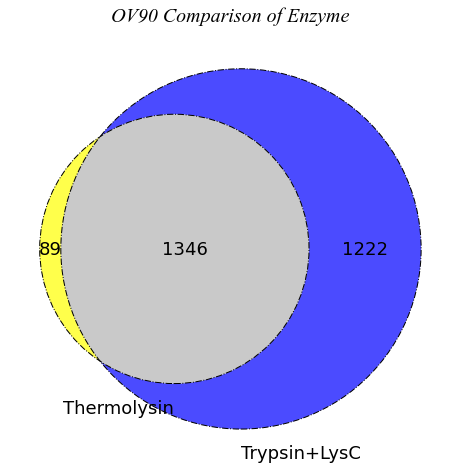

In [34]:
x=set(OV90_Thermolysin.Protein)
x2=set(OV90_TrypLysC.Protein)
plt.figure(figsize=(8,8))
vd2=venn2([x, x2],set_labels=('Thermolysin', 'Trypsin+LysC'),set_colors=('yellow', 'blue'), alpha = 0.7)
venn2_circles([x,x2], linestyle='-.', linewidth=1, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('OV90 Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=15,backgroundcolor='#ffffff',color='black',style='italic');
plt.savefig("OV90_venn.eps",dpi=dpi)
plt.show()

### OVCAR3 Enzyme Comparison

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


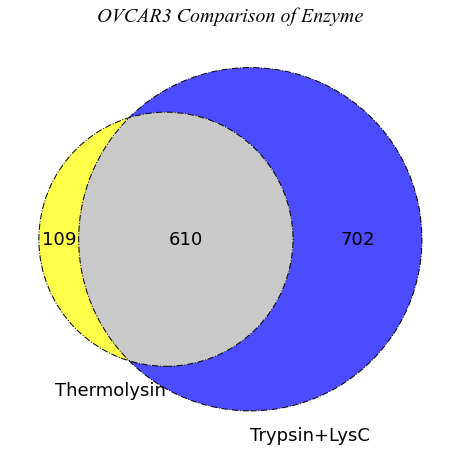

In [35]:
x=set(OVCAR3_Thermolysin.Protein)
x2=set(OVCAR3_TrypLysC.Protein)
plt.figure(figsize=(8,8))
vd2=venn2([x, x2],set_labels=('Thermolysin', 'Trypsin+LysC'),set_colors=('yellow', 'blue'), alpha = 0.7)
venn2_circles([x,x2], linestyle='-.', linewidth=1, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('OVCAR3 Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=15,backgroundcolor='#ffffff',color='black',style='italic');
plt.savefig("OVCAR3_venn.eps",dpi=dpi)
plt.show()

### hIOSE Enzyme Comparison

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


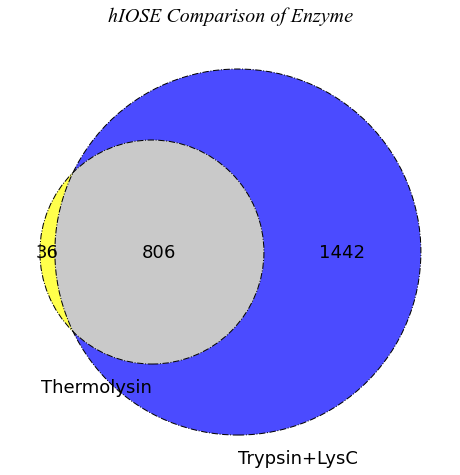

In [36]:
x=set(hIOSE_Thermolysin.Protein)
x2=set(hIOSE_TrypLysC.Protein)
plt.figure(figsize=(8,8))
vd2=venn2([x, x2],set_labels=('Thermolysin', 'Trypsin+LysC'),set_colors=('yellow', 'blue'), alpha = 0.7)
venn2_circles([x,x2], linestyle='-.', linewidth=1, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('hIOSE Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=15,backgroundcolor='#ffffff',color='black',style='italic');
plt.savefig("hIOSE_venn.eps",dpi=dpi)
plt.show()

### EOC6 Enzyme Comparison

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


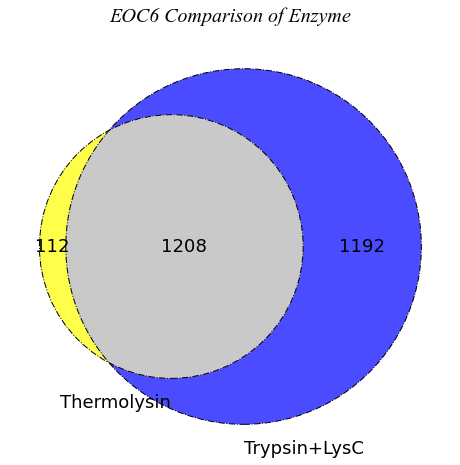

In [37]:
x=set(EOC6_Thermolysin.Protein)
x2=set(EOC6_TrypLysC.Protein)
plt.figure(figsize=(8,8))
vd2=venn2([x, x2],set_labels=('Thermolysin', 'Trypsin+LysC'),set_colors=('yellow', 'blue'), alpha = 0.7)
venn2_circles([x,x2], linestyle='-.', linewidth=1, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('EOC6 Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=15,backgroundcolor='#ffffff',color='black',style='italic');
plt.savefig("EOC6_venn.eps",dpi=dpi)
plt.show()

### EOC18 Enzyme Comparison

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


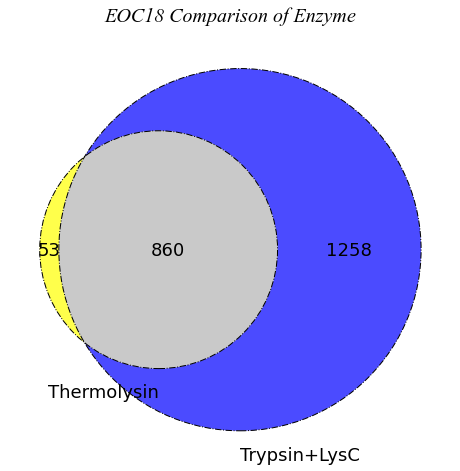

In [38]:
x=set(EOC18_Thermolysin.Protein)
x2=set(EOC18_TrypLysC.Protein)
plt.figure(figsize=(8,8))
vd2=venn2([x, x2],set_labels=('Thermolysin', 'Trypsin+LysC'),set_colors=('yellow', 'blue'), alpha = 0.7)
venn2_circles([x,x2], linestyle='-.', linewidth=1, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('EOC18 Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=15,backgroundcolor='#ffffff',color='black',style='italic');
plt.savefig("EOC18_venn.eps",dpi=dpi)
plt.show()

### Enzyme Comparison (Union of Cell Lines)

In [39]:
Thermolysin_ID= set(OV90_Thermolysin.Protein)|set(OV90_Thermolysin.Protein)|set(OVCAR3_Thermolysin.Protein)|set(hIOSE_Thermolysin.Protein)|set(EOC6_Thermolysin.Protein)|set(EOC18_Thermolysin.Protein)
len(Thermolysin_ID)

2063

In [40]:
TL_ID= set(OV90_TrypLysC.Protein)|set(OV90_TrypLysC.Protein)|set(OVCAR3_TrypLysC.Protein)|set(hIOSE_TrypLysC.Protein)|set(EOC6_TrypLysC.Protein)|set(EOC18_TrypLysC.Protein)
len(TL_ID)

3685

In [41]:
raws=set(TL_ID)|(Thermolysin_ID)
%store raws

Stored 'raws' (set)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


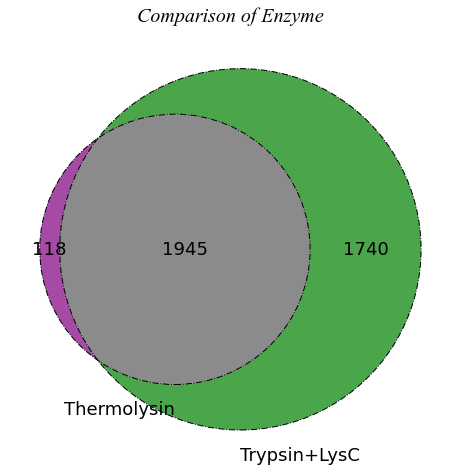

In [42]:
x=set(Thermolysin_ID)
x2=set(TL_ID)
plt.figure(figsize=(8,8))
vd2=venn2([x, x2],set_labels=('Thermolysin', 'Trypsin+LysC'),set_colors=('purple', 'green'), alpha = 0.7)
venn2_circles([x,x2], linestyle='-.', linewidth=1, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=15,backgroundcolor='#ffffff',color='black',style='italic');
plt.savefig("Enzyme_Venn.eps",dpi=dpi)
plt.show()

## Peptide Figures

In [43]:
dataframes=[OV90_Thermolysin,OV90_TrypLysC,OVCAR3_Thermolysin,OVCAR3_TrypLysC,hIOSE_Thermolysin,hIOSE_TrypLysC
           ,EOC6_Thermolysin,EOC6_TrypLysC,EOC18_Thermolysin,EOC18_TrypLysC]
lines=["OV90","OV90","OVCAR3","OVCAR3","hIOSE","hIOSE","EOC6","EOC6","EOC18","EOC18"]
enzymes=["Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC",]
## Marker and Colour Dictionary
markers={"OV90":"o","OVCAR3":"s","hIOSE":"+","EOC6":"*","EOC18":"x"}
colors={"Thermolysin":"purple","TrypLysC":"green"}
colors2 = {"OV90_Thermolysin":"purple","OV90_TrypLysC":"green","OVCAR3_Thermolysin":"purple","OVCAR3_TrypLysC":"green","hIOSE_Thermolysin":"purple","hIOSE_TrypLysC":"green"
           ,"EOC6_Thermolysin":"purple","EOC6_TrypLysC":"green","EOC18_Thermolysin":"purple","EOC18_TrypLysC":"green"}

In [44]:
labels=["OV90_T","OV90_L","OVCAR3_T","OVCAR3_L","hIOSE_T","hIOSE_L","EOC6_T","EOC6_L","EOC18_T","EOC18_L"]
for df,label in zip (dataframes,labels):
    for ruler in rulers:
        if ruler != "m/z":
            x = str(label+"_"+ruler)
            globals()[str(x)]=df[ruler]
        else:
            temp = ruler
            ruler = "mz"
            x = str(label+"_"+ruler)
            globals()[str(x)]=df[temp]

### Peptide ID vs Protein IDs

In [45]:
dataframes=[OV90_Thermolysin,OV90_TrypLysC,OVCAR3_Thermolysin,OVCAR3_TrypLysC,hIOSE_Thermolysin,hIOSE_TrypLysC
           ,EOC6_Thermolysin,EOC6_TrypLysC,EOC18_Thermolysin,EOC18_TrypLysC]
lines=["OV90","OV90","OVCAR3","OVCAR3","hIOSE","hIOSE","EOC6","EOC6","EOC18","EOC18"]
enzymes=["Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC",]
peptide_counts=[]
protein_counts=[]

for frame in dataframes:
    x=len(frame)
    peptide_counts.append(x)
    temp_frame=frame.groupby(by="Protein").mean()
    y=len(temp_frame)
    protein_counts.append(y)
print(peptide_counts,protein_counts)

[6164, 17706, 2199, 6075, 2922, 13397, 5749, 16126, 3367, 12586] [1435, 2568, 719, 1312, 842, 2248, 1320, 2400, 913, 2118]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


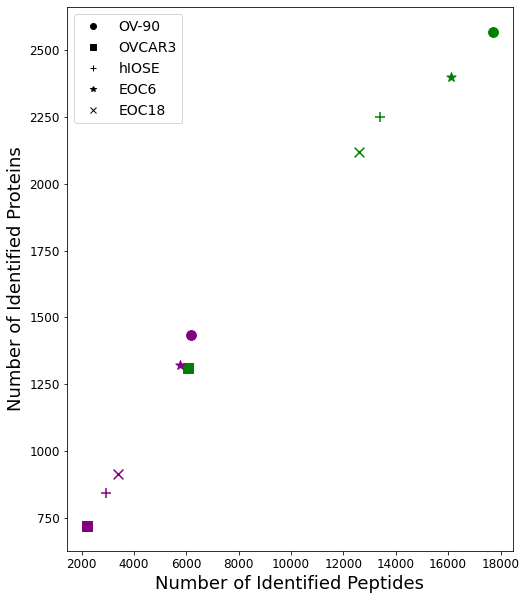

In [46]:
nums=np.arange(0,len(peptide_counts))

plt.figure(figsize=(8,10))
for line,enzyme,num in zip(lines,enzymes,nums):
      plt.scatter(peptide_counts[num],protein_counts[num],color=colors[enzyme],marker=markers[line], s=96)
plt.xticks(fontsize=12)
plt.xlabel("Number of Identified Peptides",fontsize=18)
plt.yticks(fontsize=12)
plt.ylabel("Number of Identified Proteins",fontsize=18)

ov90=plt.Line2D([0,0],[0,0], color='black', marker='o', linestyle='')
ovcar3=plt.Line2D([0,0],[0,0], color='black', marker='s', linestyle='')
hiose=plt.Line2D([0,0],[0,0], color='black', marker='+', linestyle='')
eoc6=plt.Line2D([0,0],[0,0], color='black', marker='*', linestyle='')
eoc18=plt.Line2D([0,0],[0,0], color='black', marker='x', linestyle='')

plt.legend([ov90,ovcar3,hiose,eoc6,eoc18],["OV-90","OVCAR3","hIOSE","EOC6","EOC18"],fontsize=14)
plt.savefig("PepvsPro.eps",dpi=1200,bbox_inches='tight')



### Proteins with >1 Peptide ID

In [47]:
above=[]
below=[]

for frame in dataframes:
    chicken,pot,pie = Chef.Wishbone(frame, "Protein",split=1)
    pie=round(pie,2)
    above.append(pie)
    temp=100-float(pie)
    temp=round(temp,2)
    below.append(temp)
print(above,below)

The number of proteins with > 1 peptides : 854.0
Ratio of Proteins with > 1 Peptides Identified: 59.512
The number of proteins with > 1 peptides : 1860.0
Ratio of Proteins with > 1 Peptides Identified: 72.430
The number of proteins with > 1 peptides : 352.0
Ratio of Proteins with > 1 Peptides Identified: 48.957
The number of proteins with > 1 peptides : 819.0
Ratio of Proteins with > 1 Peptides Identified: 62.424
The number of proteins with > 1 peptides : 447.0
Ratio of Proteins with > 1 Peptides Identified: 53.088
The number of proteins with > 1 peptides : 1582.0
Ratio of Proteins with > 1 Peptides Identified: 70.374
The number of proteins with > 1 peptides : 788.0
Ratio of Proteins with > 1 Peptides Identified: 59.697
The number of proteins with > 1 peptides : 1684.0
Ratio of Proteins with > 1 Peptides Identified: 70.167
The number of proteins with > 1 peptides : 521.0
Ratio of Proteins with > 1 Peptides Identified: 57.065
The number of proteins with > 1 peptides : 1448.0
Ratio of Pr

In [48]:
df = pd.DataFrame(columns=["Group","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC","Thermolysin","TrypLysC"], 
                  data=[["= 1 Peptide",below[0],below[1],below[2],below[3],below[4],below[5],below[6],below[7],below[8],below[9]],
                        ["> 1 Peptide",above[0],above[1],above[2],above[3],above[4],above[5],above[6],above[7],above[8],above[9]],
])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


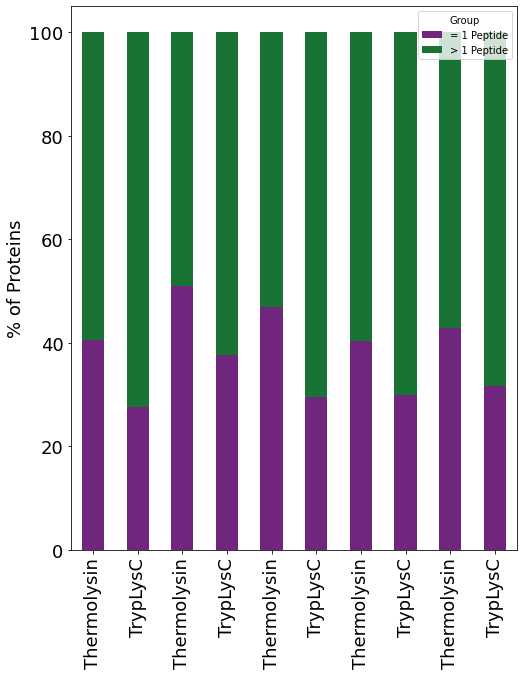

In [49]:
from matplotlib.colors import ListedColormap

df.set_index('Group')\
  .reindex(df.set_index('Group').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("PRGn", 10)), 
          figsize=(8,10))
plt.ylabel("% of Proteins",fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18,rotation=90)
plt.savefig('Stacked_Peptide_per_Protein.eps',format=fmt,dpi=dpi,bbox_inches="tight")

### Peptide Length

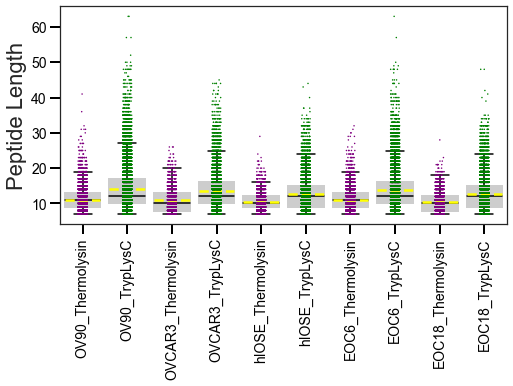

In [50]:
x=[OV90_T_Length,OV90_L_Length,OVCAR3_T_Length,OVCAR3_L_Length,hIOSE_T_Length,hIOSE_L_Length,EOC6_T_Length,EOC6_L_Length,EOC18_T_Length,EOC18_L_Length]
length=pd.concat([i for i in x], axis=1)
length.columns = ["OV90_Thermolysin","OV90_TrypLysC","OVCAR3_Thermolysin","OVCAR3_TrypLysC","hIOSE_Thermolysin","hIOSE_TrypLysC"
           ,"EOC6_Thermolysin","EOC6_TrypLysC","EOC18_Thermolysin","EOC18_TrypLysC"]
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=length,palette=colors2,s=1.5)
sns.boxplot(data=length,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide Length",fontsize=22)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('Peptide_Length',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

### Peptide Mass

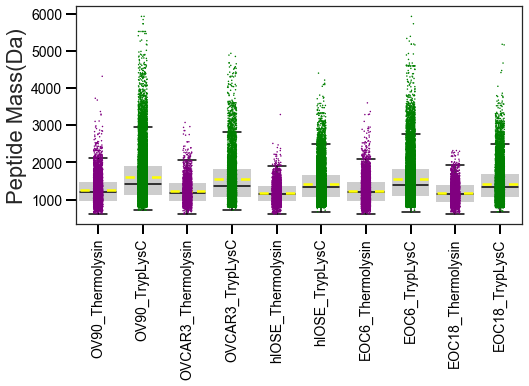

In [51]:
x=[OV90_T_Mass,OV90_L_Mass,OVCAR3_T_Mass,OVCAR3_L_Mass,hIOSE_T_Mass,hIOSE_L_Mass,EOC6_T_Mass,EOC6_L_Mass,EOC18_T_Mass,EOC18_L_Mass]
mass=pd.concat([i for i in x], axis=1)
mass.columns = ["OV90_Thermolysin","OV90_TrypLysC","OVCAR3_Thermolysin","OVCAR3_TrypLysC","hIOSE_Thermolysin","hIOSE_TrypLysC"
           ,"EOC6_Thermolysin","EOC6_TrypLysC","EOC18_Thermolysin","EOC18_TrypLysC"]
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=mass,palette=colors2,s=1.5)
sns.boxplot(data=mass,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide Mass(Da)",fontsize=22)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('Peptide_Mass',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

### Peptide Charge

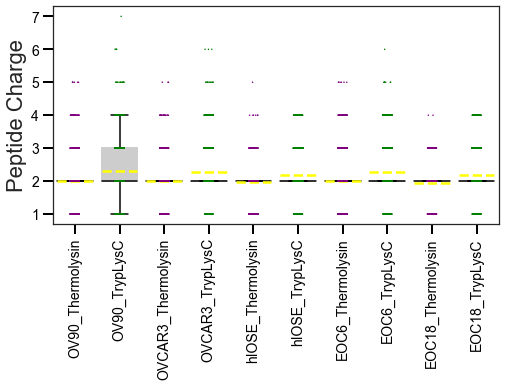

In [52]:
x=[OV90_T_z,OV90_L_z,OVCAR3_T_z,OVCAR3_L_z,hIOSE_T_z,hIOSE_L_z,EOC6_T_z,EOC6_L_z,EOC18_T_z,EOC18_L_z]
charge=pd.concat([i for i in x], axis=1)
charge.columns = ["OV90_Thermolysin","OV90_TrypLysC","OVCAR3_Thermolysin","OVCAR3_TrypLysC","hIOSE_Thermolysin","hIOSE_TrypLysC"
           ,"EOC6_Thermolysin","EOC6_TrypLysC","EOC18_Thermolysin","EOC18_TrypLysC"]
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=charge,palette=colors2,s=1.5)
sns.boxplot(data=charge,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide Charge",fontsize=22)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('Peptide_Charge',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

### Peptide GRAVY

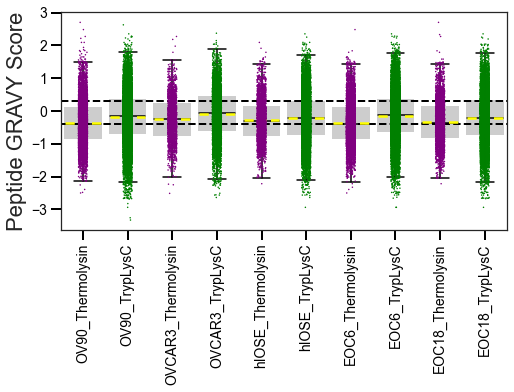

In [53]:
x=[OV90_T_Hydro_Sum,OV90_L_Hydro_Sum,OVCAR3_T_Hydro_Sum,OVCAR3_L_Hydro_Sum,hIOSE_T_Hydro_Sum,hIOSE_L_Hydro_Sum,EOC6_T_Hydro_Sum,EOC6_L_Hydro_Sum,EOC18_T_Hydro_Sum,EOC18_L_Hydro_Sum]
gravy=pd.concat([i for i in x], axis=1)
gravy.columns = ["OV90_Thermolysin","OV90_TrypLysC","OVCAR3_Thermolysin","OVCAR3_TrypLysC","hIOSE_Thermolysin","hIOSE_TrypLysC"
           ,"EOC6_Thermolysin","EOC6_TrypLysC","EOC18_Thermolysin","EOC18_TrypLysC"]
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=gravy,palette=colors2,s=1.5)
sns.boxplot(data=gravy,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide GRAVY Score",fontsize=22)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('Peptide_GRAVY',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

## Time Sequence

In [54]:
x=[OV90_T_RT,OV90_L_RT,OVCAR3_T_RT,OVCAR3_L_RT,hIOSE_T_RT,hIOSE_L_RT,EOC6_T_RT,EOC6_L_RT,EOC18_T_RT,EOC18_L_RT]
RT=pd.concat([i for i in x], axis=1)
RT.columns = ["OV90_Thermolysin","OV90_TrypLysC","OVCAR3_Thermolysin","OVCAR3_TrypLysC","hIOSE_Thermolysin","hIOSE_TrypLysC"
           ,"EOC6_Thermolysin","EOC6_TrypLysC","EOC18_Thermolysin","EOC18_TrypLysC"]
RT.describe()

,OV90_Thermolysin,OV90_TrypLysC,OVCAR3_Thermolysin,OVCAR3_TrypLysC,hIOSE_Thermolysin,hIOSE_TrypLysC,EOC6_Thermolysin,EOC6_TrypLysC,EOC18_Thermolysin,EOC18_TrypLysC
count,6164.000000,17706.000000,2199.000000,6075.000000,2922.000000,13397.000000,5749.000000,16126.000000,3367.000000,12586.000000
mean,30.064739,38.765335,32.312483,38.930403,29.128008,36.069512,29.406358,38.399726,28.741084,36.348645
std,8.234994,12.871505,7.981601,12.082985,6.651056,8.786505,7.952612,11.364854,7.016236,9.541586
min,14.210000,14.740000,16.110000,15.900000,16.810000,15.900000,13.900000,14.740000,14.680000,14.740000
25%,23.540000,29.370000,25.705000,30.130000,23.952500,29.100000,22.960000,29.840000,23.130000,28.680000
50%,28.405000,38.180000,31.480000,38.120000,27.935000,36.090000,27.780000,38.140000,27.300000,36.330000
75%,36.110000,46.847500,38.780000,46.230000,33.317500,43.080000,35.230000,46.190000,33.585000,44.010000
max,132.300000,135.670000,74.660000,134.000000,51.510000,132.790000,55.210000,133.280000,50.440000,132.780000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


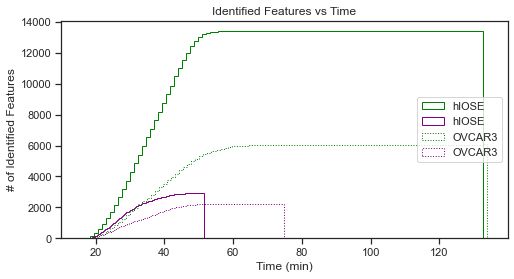

In [55]:
mu = 200
sigma = 25
n_bins = 100
x = RT.hIOSE_TrypLysC
y = RT.hIOSE_Thermolysin
z = RT.OVCAR3_TrypLysC
w = RT.OVCAR3_Thermolysin
fig, ax = plt.subplots(figsize=(8, 4))
sns.set_style("ticks")

# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, density=False, histtype='step',
                           cumulative=True, label='hIOSE',color='green')

n, bins, patches = ax.hist(y, n_bins, density=False, histtype='step',
                           cumulative=True, label='hIOSE',color='purple')

n, bins, patches = ax.hist(z, n_bins, density=False, histtype='step',
                           cumulative=True, label='OVCAR3',color='green',linestyle=':')

n, bins, patches = ax.hist(w, n_bins, density=False, histtype='step',
                           cumulative=True, label='OVCAR3',color='purple',linestyle=':')
# tidy up the figure
ax.grid(False)
ax.legend(loc='right')
ax.set_title('Identified Features vs Time')
ax.set_xlabel('Time (min)')
ax.set_ylabel('# of Identified Features')
plt.savefig("FeaturesvsTime.eps",dpi=600)
plt.show()

## Protein Figures

In [56]:
og = pd.read_csv("proteins.csv")
og[['Protein', 'Gene']] = og['Accession'].str.split('|', 1, expand=True)
og_info=og[['Protein ID','Protein', 'Gene','Avg. Mass','Score (%)','-10lgP','Coverage (%)','#Peptides']]
og.head()

,Protein Group,Protein ID,Accession,Score (%),-10lgP,Coverage (%),Coverage (%) OV90_Thermolysin,Coverage (%) OV90_TrypLysC,Coverage (%) OVCAR3_Thermolysin,Coverage (%) OVAR3_TrypLysC,Coverage (%) hIOSE_Thermolysin,Coverage (%) hIOSE_TrypLysC,Coverage (%) EOC18_Thermolysin,Coverage (%) EOC18_TrypLysC,Coverage (%) EOC6_Thermolysin,Coverage (%) EOC6_TrypLysC,Area OV90_Thermolysin,Area OV90_TrypLysC,Area OVCAR3_Thermolysin,Area OVAR3_TrypLysC,Area hIOSE_Thermolysin,Area hIOSE_TrypLysC,Area EOC18_Thermolysin,Area EOC18_TrypLysC,Area EOC6_Thermolysin,Area EOC6_TrypLysC,#Peptides,#Unique,#Spec OV90_Thermolysin,#Spec OV90_TrypLysC,#Spec OVCAR3_Thermolysin,#Spec OVAR3_TrypLysC,#Spec hIOSE_Thermolysin,#Spec hIOSE_TrypLysC,#Spec EOC18_Thermolysin,#Spec EOC18_TrypLysC,#Spec EOC6_Thermolysin,#Spec EOC6_TrypLysC,PTM,Avg. Mass,Description,Protein,Gene
0,1,11,P02751|FINC_HUMAN,99.2,544.78,81,51,62,17,37,29,41,46,52,37,57,5.535000e+10,1.478900e+11,1.489000e+09,2.209900e+09,2.428600e+09,8.865500e+09,1.733100e+10,4.180600e+10,8.078900e+09,1.541600e+10,310,310,539,1069,90,130,163,294,414,485,226,325,Carbamidomethylation; Deamidation (NQ); Oxidat...,272318,Fibronectin OS=Homo sapiens OX=9606 GN=FN1 PE=...,P02751,FINC_HUMAN
1,6,116,Q09666|AHNK_HUMAN,99.2,488.65,45,9,22,2,3,8,36,7,29,10,21,3.770900e+08,1.743700e+09,1.108400e+07,3.296300e+07,1.224000e+08,1.893500e+09,1.770100e+08,1.492100e+09,3.896200e+08,1.321200e+09,275,275,87,148,10,17,65,336,67,243,94,167,Carbamidomethylation; Deamidation (NQ); Oxidat...,629114,Neuroblast differentiation-associated protein ...,Q09666,AHNK_HUMAN
2,5,66,P98160|PGBM_HUMAN,99.2,483.64,57,12,34,5,20,8,23,9,25,18,41,6.165800e+08,2.979500e+09,9.880500e+07,3.811900e+08,1.548100e+08,5.232600e+08,3.559300e+08,1.080300e+09,1.505600e+09,3.902900e+09,220,220,75,210,24,97,53,150,62,176,135,292,Carbamidomethylation; Deamidation (NQ); Oxidat...,468835,Basement membrane-specific heparan sulfate pro...,P98160,PGBM_HUMAN
3,7,61,Q14204|DYHC1_HUMAN,99.2,462.04,54,6,42,2,13,2,23,4,29,8,42,2.331000e+08,2.762400e+09,1.739200e+07,8.333200e+07,3.845200e+08,3.936200e+08,3.054100e+08,8.066600e+08,3.722000e+08,2.842200e+09,236,236,37,305,15,62,14,172,22,208,58,329,Carbamidomethylation; Deamidation (NQ); Oxidat...,532412,Cytoplasmic dynein 1 heavy chain 1 OS=Homo sap...,Q14204,DYHC1_HUMAN
4,11,36,P49327|FAS_HUMAN,99.2,444.26,70,20,57,10,41,6,28,6,21,17,48,1.352700e+09,6.978800e+09,1.549300e+08,8.623000e+08,4.085000e+07,3.618200e+08,3.250900e+07,2.494500e+08,6.410400e+08,2.631300e+09,173,173,95,271,38,147,23,104,22,77,79,198,Carbamidomethylation; Deamidation (NQ); Oxidat...,273424,Fatty acid synthase OS=Homo sapiens OX=9606 GN...,P49327,FAS_HUMAN


In [57]:
combined_cov=og[["Coverage (%)","Gene","Protein"]]
combined_cov.columns=["Coverage","Gene","Protein"]
combined_cov

,Coverage,Gene,Protein
0,81,FINC_HUMAN,P02751
1,45,AHNK_HUMAN,Q09666
2,57,PGBM_HUMAN,P98160
3,54,DYHC1_HUMAN,Q14204
4,70,FAS_HUMAN,P49327
...,...,...,...
3912,6,LFNG_HUMAN,Q8NES3
3913,2,NOC4L_HUMAN,Q9BVI4
3914,1,I2BPL_HUMAN,Q9H1B7
3915,2,TXLNA_HUMAN,P40222


### TrypLysC

In [58]:
TrypLysC_og=og.loc[:, og.columns.str.contains('TrypLysC')]
TrypLysC = pd.concat([og_info, TrypLysC_og], axis=1)
TrypLysC =TrypLysC.loc[(TrypLysC['#Spec OV90_TrypLysC'] > 0) | (TrypLysC['#Spec OVAR3_TrypLysC'] > 0)| (TrypLysC['#Spec hIOSE_TrypLysC'] > 0)
                     | (TrypLysC['#Spec EOC6_TrypLysC'] > 0)| (TrypLysC['#Spec EOC18_TrypLysC'] > 0)]
TrypLysC

,Protein ID,Protein,Gene,Avg. Mass,Score (%),-10lgP,Coverage (%),#Peptides,Coverage (%) OV90_TrypLysC,Coverage (%) OVAR3_TrypLysC,Coverage (%) hIOSE_TrypLysC,Coverage (%) EOC18_TrypLysC,Coverage (%) EOC6_TrypLysC,Area OV90_TrypLysC,Area OVAR3_TrypLysC,Area hIOSE_TrypLysC,Area EOC18_TrypLysC,Area EOC6_TrypLysC,#Spec OV90_TrypLysC,#Spec OVAR3_TrypLysC,#Spec hIOSE_TrypLysC,#Spec EOC18_TrypLysC,#Spec EOC6_TrypLysC
0,11,P02751,FINC_HUMAN,272318,99.2,544.78,81,310,62,37,41,52,57,1.478900e+11,2.209900e+09,8.865500e+09,4.180600e+10,1.541600e+10,1069,130,294,485,325
1,116,Q09666,AHNK_HUMAN,629114,99.2,488.65,45,275,22,3,36,29,21,1.743700e+09,3.296300e+07,1.893500e+09,1.492100e+09,1.321200e+09,148,17,336,243,167
2,66,P98160,PGBM_HUMAN,468835,99.2,483.64,57,220,34,20,23,25,41,2.979500e+09,3.811900e+08,5.232600e+08,1.080300e+09,3.902900e+09,210,97,150,176,292
3,61,Q14204,DYHC1_HUMAN,532412,99.2,462.04,54,236,42,13,23,29,42,2.762400e+09,8.333200e+07,3.936200e+08,8.066600e+08,2.842200e+09,305,62,172,208,329
4,36,P49327,FAS_HUMAN,273424,99.2,444.26,70,173,57,41,28,21,48,6.978800e+09,8.623000e+08,3.618200e+08,2.494500e+08,2.631300e+09,271,147,104,77,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912,5739,Q8NES3,LFNG_HUMAN,41773,17.5,23.84,6,1,0,6,0,0,0,NaN,0.000000e+00,NaN,NaN,NaN,0,1,0,0,0
3913,6618,Q9BVI4,NOC4L_HUMAN,58468,90.2,23.83,2,1,0,0,0,0,2,NaN,NaN,NaN,NaN,1.194300e+06,0,0,0,0,1
3914,6508,Q9H1B7,I2BPL_HUMAN,82659,77.2,23.82,1,1,0,1,0,0,0,NaN,5.077300e+05,NaN,NaN,NaN,0,1,0,0,0
3915,53428,P40222,TXLNA_HUMAN,61891,71.4,23.82,2,1,2,0,0,0,0,5.394500e+05,NaN,NaN,NaN,NaN,1,0,0,0,0


In [59]:
grab=['Coverage (%) OV90_TrypLysC','Coverage (%) OVAR3_TrypLysC','Coverage (%) hIOSE_TrypLysC','Coverage (%) EOC6_TrypLysC','Coverage (%) EOC18_TrypLysC']
TrypLysC['AvgCoverage'] = TrypLysC[grab].mean(axis=1)
TrypLysC['MaxCoverage'] = TrypLysC[grab].max(axis=1)
TrypLysC_coverage=TrypLysC.loc[(TrypLysC['AvgCoverage']>0)]
TrypLysC_coverage.to_excel('TrypLysC_proteins.xlsx')
TrypLysC_coverage.describe()

,Protein ID,Avg. Mass,Score (%),-10lgP,Coverage (%),#Peptides,Coverage (%) OV90_TrypLysC,Coverage (%) OVAR3_TrypLysC,Coverage (%) hIOSE_TrypLysC,Coverage (%) EOC18_TrypLysC,Coverage (%) EOC6_TrypLysC,Area OV90_TrypLysC,Area OVAR3_TrypLysC,Area hIOSE_TrypLysC,Area EOC18_TrypLysC,Area EOC6_TrypLysC,#Spec OV90_TrypLysC,#Spec OVAR3_TrypLysC,#Spec hIOSE_TrypLysC,#Spec EOC18_TrypLysC,#Spec EOC6_TrypLysC,AvgCoverage,MaxCoverage
count,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000,2.476000e+03,1.184000e+03,2.132000e+03,2.007000e+03,2.299000e+03,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000,3741.000000
mean,6256.959636,70764.860732,94.693077,131.284253,20.545576,10.262764,12.144346,4.749800,8.374499,7.971398,10.270516,4.161269e+08,2.225408e+08,6.759173e+07,1.154474e+08,1.923709e+08,11.234964,3.500401,7.068698,6.604651,9.036354,8.702112,16.602780
std,10266.538546,65871.953275,9.735616,85.210795,20.232258,17.792060,16.731299,10.594366,12.622282,12.844816,15.347457,4.770607e+09,3.082737e+09,3.805267e+08,1.045000e+09,1.402101e+09,44.069550,15.555208,17.580383,17.629341,22.679416,12.138896,17.344756
min,1.000000,5053.000000,17.500000,23.810000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,1.000000
25%,994.000000,32574.000000,95.900000,60.530000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.174600e+06,1.454300e+06,9.575850e+05,1.178100e+06,1.915900e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
50%,2131.000000,52879.000000,99.000000,114.070000,13.000000,5.000000,5.000000,0.000000,3.000000,2.000000,3.000000,1.728950e+07,7.442300e+06,4.664650e+06,6.162600e+06,1.062700e+07,2.000000,0.000000,2.000000,1.000000,2.000000,3.600000,10.000000
75%,6640.000000,87058.000000,99.200000,183.580000,30.000000,12.000000,17.000000,3.000000,11.000000,10.000000,13.000000,1.212675e+08,3.978925e+07,2.823675e+07,3.929250e+07,7.610250e+07,10.000000,2.000000,7.000000,6.000000,8.000000,10.800000,23.000000
max,54170.000000,838323.000000,99.200000,544.780000,91.000000,310.000000,90.000000,80.000000,91.000000,74.000000,80.000000,1.728100e+11,9.919600e+10,9.402200e+09,4.180600e+10,5.456000e+10,2052.000000,632.000000,336.000000,485.000000,358.000000,76.400000,91.000000


### Thermolysin

In [60]:
Thermo_og=og.loc[:, og.columns.str.contains('Thermolysin')]
Thermo = pd.concat([og_info, Thermo_og], axis=1)
Thermo =Thermo.loc[(Thermo['#Spec OV90_Thermolysin'] > 0) | (Thermo['#Spec OVCAR3_Thermolysin'] > 0)| (Thermo['#Spec hIOSE_Thermolysin'] > 0)
                     | (Thermo['#Spec EOC6_Thermolysin'] > 0)| (Thermo['#Spec EOC18_Thermolysin'] > 0)]
Thermo

,Protein ID,Protein,Gene,Avg. Mass,Score (%),-10lgP,Coverage (%),#Peptides,Coverage (%) OV90_Thermolysin,Coverage (%) OVCAR3_Thermolysin,Coverage (%) hIOSE_Thermolysin,Coverage (%) EOC18_Thermolysin,Coverage (%) EOC6_Thermolysin,Area OV90_Thermolysin,Area OVCAR3_Thermolysin,Area hIOSE_Thermolysin,Area EOC18_Thermolysin,Area EOC6_Thermolysin,#Spec OV90_Thermolysin,#Spec OVCAR3_Thermolysin,#Spec hIOSE_Thermolysin,#Spec EOC18_Thermolysin,#Spec EOC6_Thermolysin
0,11,P02751,FINC_HUMAN,272318,99.2,544.78,81,310,51,17,29,46,37,5.535000e+10,1.489000e+09,2.428600e+09,1.733100e+10,8.078900e+09,539,90,163,414,226
1,116,Q09666,AHNK_HUMAN,629114,99.2,488.65,45,275,9,2,8,7,10,3.770900e+08,1.108400e+07,1.224000e+08,1.770100e+08,3.896200e+08,87,10,65,67,94
2,66,P98160,PGBM_HUMAN,468835,99.2,483.64,57,220,12,5,8,9,18,6.165800e+08,9.880500e+07,1.548100e+08,3.559300e+08,1.505600e+09,75,24,53,62,135
3,61,Q14204,DYHC1_HUMAN,532412,99.2,462.04,54,236,6,2,2,4,8,2.331000e+08,1.739200e+07,3.845200e+08,3.054100e+08,3.722000e+08,37,15,14,22,58
4,36,P49327,FAS_HUMAN,273424,99.2,444.26,70,173,20,10,6,6,17,1.352700e+09,1.549300e+08,4.085000e+07,3.250900e+07,6.410400e+08,95,38,23,22,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,8370,Q9Y5H6,PCDA8_HUMAN,103051,55.4,24.06,1,1,0,1,0,0,0,NaN,0.000000e+00,NaN,NaN,NaN,0,1,0,0,0
3902,54066,Q9UN73,PCDA6_HUMAN,102716,40.3,24.06,1,1,0,1,0,0,0,NaN,0.000000e+00,NaN,NaN,NaN,0,1,0,0,0
3903,7651,O14525,ASTN1_HUMAN,144913,85.3,24.05,1,1,0,0,0,0,1,NaN,NaN,NaN,NaN,6.824000e+06,0,0,0,0,1
3907,4968,Q6ZMM2,ATL5_HUMAN,53194,72.9,23.91,1,1,0,1,0,0,0,NaN,1.891100e+07,NaN,NaN,NaN,0,1,0,0,0


In [61]:
grab=['Coverage (%) OV90_Thermolysin','Coverage (%) OVCAR3_Thermolysin','Coverage (%) hIOSE_Thermolysin','Coverage (%) EOC6_Thermolysin','Coverage (%) EOC18_Thermolysin']
Thermo['AvgCoverage'] = Thermo[grab].mean(axis=1)
Thermo['MaxCoverage'] = Thermo[grab].max(axis=1)
Thermo_coverage=Thermo.loc[(Thermo['AvgCoverage']>0)]
Thermo_coverage.to_excel('Thermo_proteins.xlsx')
Thermo_coverage.describe()

,Protein ID,Avg. Mass,Score (%),-10lgP,Coverage (%),#Peptides,Coverage (%) OV90_Thermolysin,Coverage (%) OVCAR3_Thermolysin,Coverage (%) hIOSE_Thermolysin,Coverage (%) EOC18_Thermolysin,Coverage (%) EOC6_Thermolysin,Area OV90_Thermolysin,Area OVCAR3_Thermolysin,Area hIOSE_Thermolysin,Area EOC18_Thermolysin,Area EOC6_Thermolysin,#Spec OV90_Thermolysin,#Spec OVCAR3_Thermolysin,#Spec hIOSE_Thermolysin,#Spec EOC18_Thermolysin,#Spec EOC6_Thermolysin,AvgCoverage,MaxCoverage
count,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,1.245000e+03,5.830000e+02,6.890000e+02,7.560000e+02,1.167000e+03,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000
mean,3333.289952,69041.086603,97.704354,176.103469,30.134928,16.166507,5.547847,2.097129,2.631100,3.124402,4.779426,1.636724e+08,7.561481e+07,2.589700e+07,4.962923e+07,8.611416e+07,4.985646,1.818660,2.328708,2.567943,4.540191,3.635981,7.913397
std,6949.995280,63325.395433,5.908381,84.524304,21.448503,21.967207,7.718718,4.292740,5.057571,5.704032,7.018041,2.069941e+09,5.378421e+08,1.447508e+08,6.368462e+08,7.123887e+08,15.918317,5.759595,7.143311,10.740707,11.822914,5.077091,8.068084
min,1.000000,7318.000000,40.300000,23.910000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,1.000000
25%,561.250000,32238.250000,99.000000,113.957500,12.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.218200e+06,1.130200e+06,8.012600e+05,1.129750e+06,2.016300e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,3.000000
50%,1198.500000,51847.000000,99.200000,168.755000,25.000000,10.000000,3.000000,0.000000,0.000000,0.000000,2.000000,8.921300e+06,4.517200e+06,2.666200e+06,3.973250e+06,7.393400e+06,2.000000,0.000000,0.000000,0.000000,1.000000,1.600000,5.000000
75%,2327.500000,85121.500000,99.200000,234.112500,45.000000,19.750000,7.000000,2.000000,3.000000,4.000000,6.000000,3.989000e+07,1.878200e+07,9.175000e+06,1.329350e+07,3.126650e+07,5.000000,1.000000,2.000000,2.000000,4.000000,4.400000,10.000000
max,54066.000000,629114.000000,99.200000,544.780000,91.000000,310.000000,62.000000,31.000000,39.000000,46.000000,56.000000,5.535000e+10,1.072600e+10,2.428600e+09,1.733100e+10,2.178200e+10,539.000000,103.000000,163.000000,414.000000,226.000000,36.400000,62.000000


### Sequence Coverage (Combined vs TrypLysC vs Thermolysin)

In [62]:
#Dataframe for Coverages
coverage = [TrypLysC.AvgCoverage,Thermo.AvgCoverage,combined_cov.Coverage]
xx = pd.concat([i for i in coverage], axis=1)
xx.columns = ['TrypLysC','Thermolysin','Combined']
df1 = xx.stack().reset_index()
df1.columns = ['Null','Digest','Coverage']
df1.drop(['Null'], axis=1, inplace=True)
df1

,Digest,Coverage
0,TrypLysC,49.8
1,Thermolysin,36.0
2,Combined,81.0
3,TrypLysC,22.2
4,Thermolysin,7.2
...,...,...
9821,Combined,1.0
9822,TrypLysC,0.4
9823,Combined,2.0
9824,TrypLysC,0.4


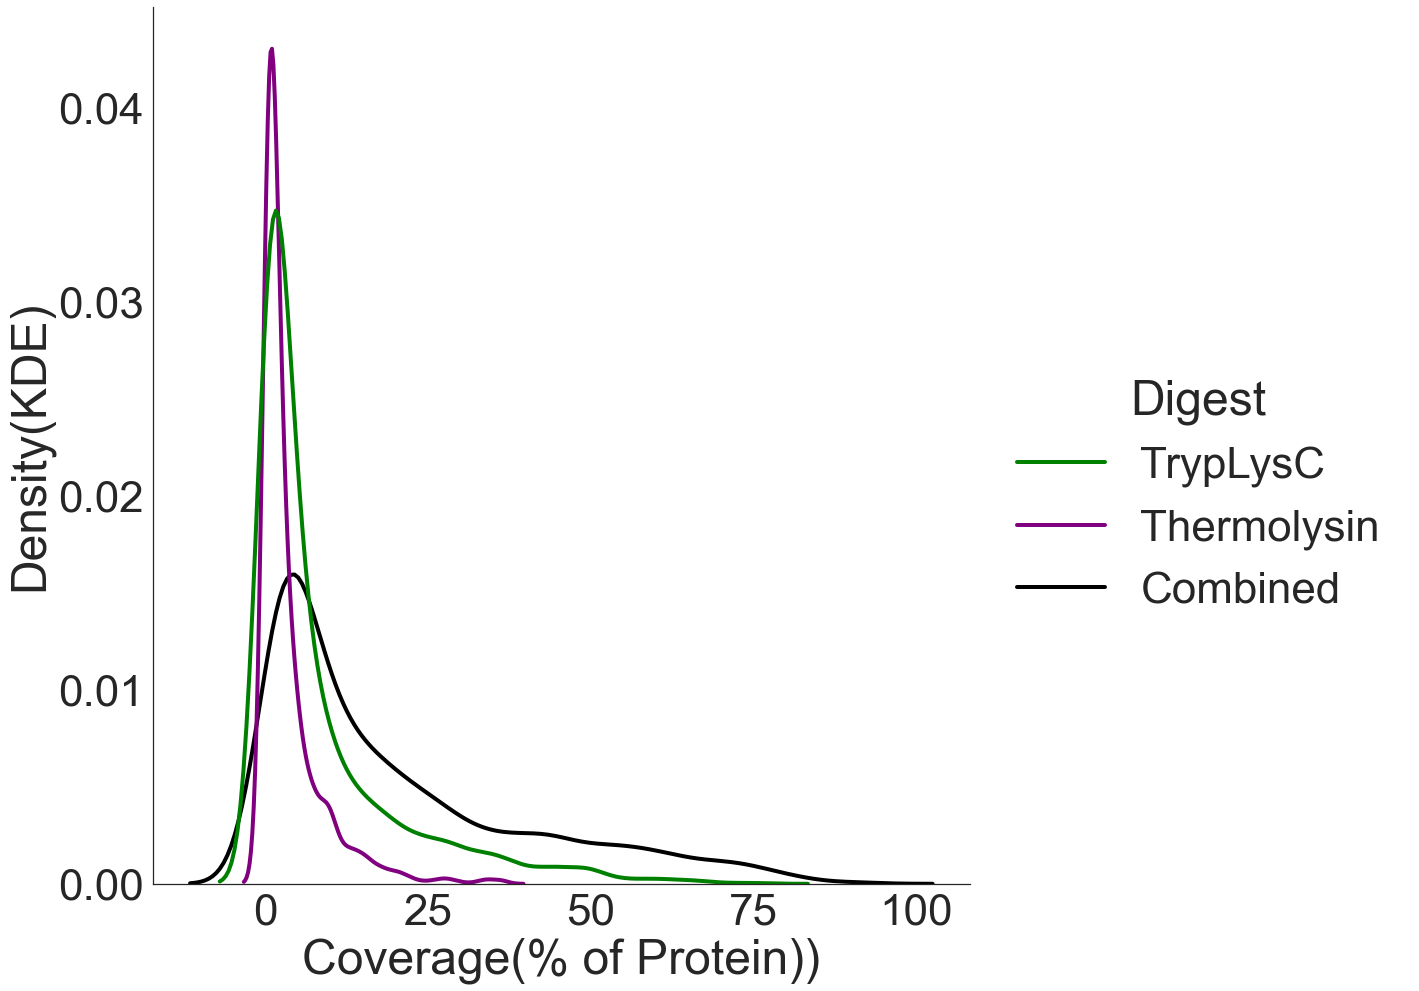

In [63]:
colors = {"TrypLysC":"green","Thermolysin":"purple","Combined":"black"}
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Coverage", hue="Digest",palette=colors,
    kind="kde", height=15,log_scale=(0,0),linewidth=4
    
)
plt.xlabel('Coverage(% of Protein))', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
# plt.title('Kernel Density Estimation of Sequence Coverage',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
g.savefig("Coverage_KDE.eps",dpi=600)

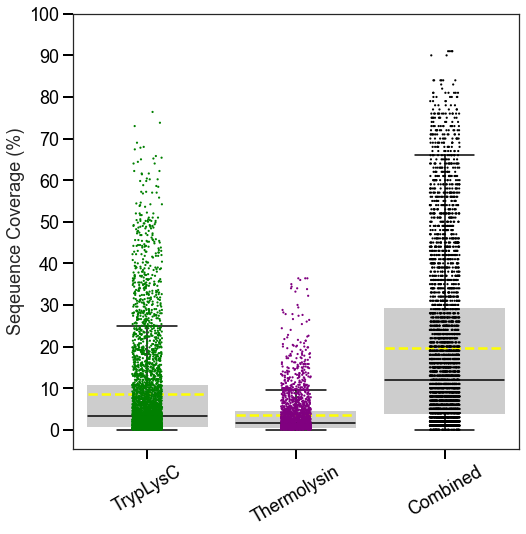

In [64]:
sns.set(rc={'figure.figsize':(8,8)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=xx,palette=colors,s=2.2)
sns.boxplot(data=xx,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Seqeuence Coverage (%)",fontsize=18)
plt.xticks(fontsize=18,rotation=30)
plt.yticks(np.arange(0,101,10),fontsize=18)
plt.savefig('Coverage.eps',dpi=dpi,bbox_inches="tight")
plt.show()

## Surfaceome

In [65]:
surfaceome = pd.read_excel("Surfaceome.xlsx")
surfaceome.head()

,UniProt name,UniProt accession,UniProt description,UniProt gene,Surfaceome Label,Surfaceome Label Source,length,TM domains,signalpeptide,topology,topology source,SURFY score,"MachineLearning FPR class (1=1%, 2=5%, 3=15%)",Ensembl gene,Ensembl protein,CD number,Membranome Almen main-class,Membranome Almen sub-class,nxst motifs,noncyt. nxst count,UniProt subcellular,UniProt keywords
0,S12A8,A0AV02,Solute carrier family 12 member 8,SLC12A8,surface,machine learning,714,13,0,NC:1-37;TM:38-60;CY:61-71;TM:72-93;NC:94-98;TM...,phobius,0.8363,1,ENSG00000221955,ENSP00000377112;ENSP00000415713;ENSP00000418783,NaN,Transporters,SLC;APC;SLC12,221;357;483;561;645,1,Membrane (Multi-pass membrane protein),Alternative splicing;Chloride;Complete proteom...
1,ESYT3,A0FGR9,Extended synaptotagmin-3,ESYT3,surface,pos. trainingset,886,2,0,CY:1-27;TM:28-46;NC:47-51;TM:52-72;CY:73-886,uniprot,0.0465,NaN,ENSG00000158220,ENSP00000374218,NaN,Unclassified,Unclassified,251;411;780,0,Cell membrane (Peripheral membrane protein);En...,Alternative splicing;Calcium;Cell membrane;Com...
2,SC5AA,A0PJK1,Sodium/glucose cotransporter 5,SLC5A10,surface,machine learning,596,14,0,NC:1-15;TM:16-37;CY:38-73;TM:74-93;NC:94-98;TM...,uniprot,0.8802,1,ENSG00000154025,ENSP00000379007,NaN,Transporters,SLC;APC;SLC5,4;96;239;386;545,3,Cell membrane (Multi-pass membrane protein),Alternative splicing;Cell membrane;Complete pr...
3,CLRN2,A0PK11,Clarin-2,CLRN2,surface,machine learning,232,4,0,CY:1-11;TM:12-33;NC:34-96;TM:97-124;CY:125-135...,phobius,0.6108,2,ENSG00000249581,ENSP00000424711,NaN,Unclassified,Unclassified,48,1,Membrane (Multi-pass membrane protein),Complete proteome;Glycoprotein;Membrane;Polymo...
4,CC50C,A0ZSE6,Cell cycle control protein 50C,TMEM30C,surface,machine learning,113,1,0,CY:1-34;TM:35-57;NC:58-113,uniprot,0.6327,2,ENSG00000235156,ENSP00000402698,NaN,Miscellaneous,Unknown_function;TMEM30,66;80,2,Membrane (Single-pass membrane protein),Complete proteome;Glycoprotein;Membrane;Refere...


In [66]:
surface=list(surfaceome["UniProt accession"])
len(surface)

2886

### In Silico Digestion of Human Proteome

In [67]:
%store -r meat

In [170]:
human_df=pd.DataFrame.from_dict(meat,orient='index').reset_index()
human_df.columns=["Protein","Peptide"]
len(human_df)

20614

In [69]:
Chef.Marinate(human_df,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True,Peptide_Inspector=False)
human_df["Length"]=human_df['Peptide'].astype(str).map(len)
human_df["Mass"]=human_df['Peptide'].astype(str).map(Mass)
human_df["z"]=human_df["Peptide"].apply(lambda x: electrochem.charge(x,pH=2.0))
human_df["MZ"]=human_df['Mass']/human_df['z']
len(human_df)

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


20614

#### Trypsin Digestion

In [ ]:
missed_sites=[0,1,2,3,4,5]
enzyme="trypsin"
Tryp_Peptides=[]
for site in missed_sites:
    x=f"Tryp_{site}_dig"
    z=Chef.ButcherShop(human_df,target="Peptide",identifier="Protein", rule=enzyme,min_charge=1.55,missed=site,exception=None,min_length=7,max_length=65)
    globals()[str(x)]=Chef.Deli(z,meat_package=True)
    Tryp_Peptides.append(globals()[str(x)])

You order is being processed and the butcher is preparing your trypsin-cut protein(s)!
The butcher is working...
Generating trypsin-cut peptides based on 0-missed cleavages. 
Preparing your order...
Order is up! You have acquired 557833 peptides that are between 7 and 65 amino acids!
You order is being processed and the butcher is preparing your trypsin-cut protein(s)!
The butcher is working...
Generating trypsin-cut peptides based on 1-missed cleavages. 
Preparing your order...
Order is up! You have acquired 1531143 peptides that are between 7 and 65 amino acids!
You order is being processed and the butcher is preparing your trypsin-cut protein(s)!
The butcher is working...
Generating trypsin-cut peptides based on 2-missed cleavages. 
Preparing your order...
Order is up! You have acquired 2618562 peptides that are between 7 and 65 amino acids!
You order is being processed and the butcher is preparing your trypsin-cut protein(s)!
The butcher is working...
Generating trypsin-cut peptide

In [ ]:
T_Pep_Counts=[]
#Count are in Log10
for df in Tryp_Peptides:
    log = math.log2(len(df))
    T_Pep_Counts.append(log)
plt.plot(missed_sites,T_Pep_Counts,color="black")
plt.title('Trypsin Digestion - Surfaceome',fontsize=14)
plt.xlabel('Missed Cleavages per Proteins', fontsize=14)
plt.ylabel('Log2(Number of Peptides)', fontsize=14)
plt.xticks(missed_sites,fontsize=14)
plt.yticks(np.arange(14, 26, 1),fontsize=14)
plt.ylim([14, 22])
Ratios=[]
for count in T_Pep_Counts:
    ratio=2**(count-T_Pep_Counts[0])
    ratiox=float(round(ratio,1))
    Ratios.append(ratiox)
for x_, y_, name in zip(missed_sites,T_Pep_Counts, Ratios):
    plt.text(x_-0.1,y_ + 0.5, name , fontsize=14, color="green")
plt.text(1,16,"Fold Change (rel. 0)",color="green",fontsize=14)
plt.savefig("Trypsin_Human_Peptides.eps",dpi=1200)
plt.show()

#### Thermolysin Digestion

In [ ]:
missed_sites=[0,1,2,3,4,5]
enzyme="thermolysin"
Thermo_Peptides=[]
for site in missed_sites:
    x=f"Thermo_{site}_dig"
    z=Chef.ButcherShop(human_df,target="Peptide",identifier="Protein", rule=enzyme,min_charge=1.55,missed=site,exception=None,min_length=7,max_length=65)
    globals()[str(x)]=Chef.Deli(z,meat_package=True)
    Thermo_Peptides.append(globals()[str(x)])

### In Silico Digestion of Surfaceome

In [72]:
raw_surface= {k:v for (k,v) in meat.items() if k in surface}
len(raw_surface)

2789

In [73]:
surface_df=pd.DataFrame.from_dict(raw_surface,orient='index')
surface_df.reset_index(inplace=True)
surface_df.columns=["Protein","Peptide"]
surface_df

,Protein,Peptide
0,O43869,MWQEYYFLNVFFPLLKVCCLTINSHVVILLPWECYHLIWKILPYIG...
1,P11230,MTPGALLMLLGALGAPLAPGVRGSEAEGRLREKLFSGYDSSVRPAR...
2,P52797,MAAAPLLLLLLLVPVPLLPLLAQGPGGALGNRHAVYWNSSNQHLRR...
3,P98164,MDRGPAAVACTLLLALVACLAPASGQECDSAHFRCGSGHCIPADWR...
4,Q13224,MKPRAECCSPKFWLVLAVLAVSGSRARSQKSPPSIGIAVILVGTSD...
...,...,...
2784,Q8NGZ9,MRLANQTLGGDFFLLGIFSQISHPGRLCLLIFSIFLMAVSWNITLI...
2785,Q8NH95,MVSANQTASVTEFILLGLSAHPKLEKTFFVLILLMYLVILLGNGVL...
2786,Q8TDS4,MNRHHLQDHFLEIDKKNCCVFRDDFIVKVLPPVLGLEFIFGLLGNG...
2787,Q99500,MATALPPRLQPVRGNETLREHYQYVGKLAGRLKEASEGSTLTTVLF...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


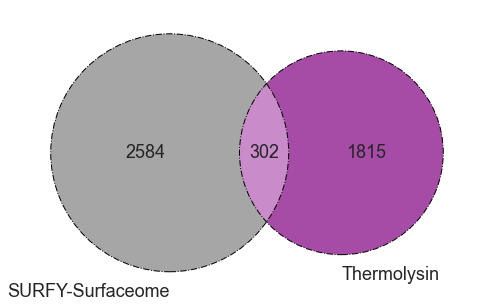

In [74]:
x=set(surface)
x2=set(Thermo.Protein)
plt.figure(figsize=(8,8))
vd2=venn2([x, x2],set_labels=('SURFY-Surfaceome', 'Thermolysin'),set_colors=('grey', 'purple'), alpha = 0.7)
venn2_circles([x,x2], linestyle='-.', linewidth=1, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
# plt.title('OV90 Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=15,backgroundcolor='#ffffff',color='black',style='italic');
plt.savefig("SurfyvsThermolysin.eps",dpi=dpi)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


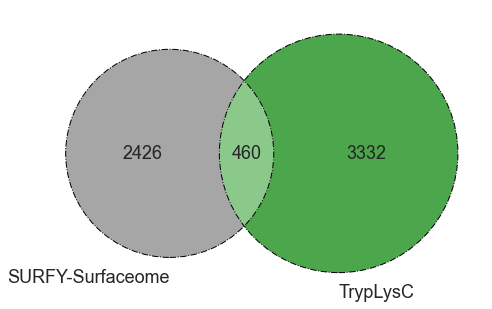

In [75]:
x=set(surface)
x2=set(TrypLysC.Protein)
plt.figure(figsize=(8,8))
vd2=venn2([x, x2],set_labels=('SURFY-Surfaceome', 'TrypLysC'),set_colors=('grey', 'green'), alpha = 0.7)
venn2_circles([x,x2], linestyle='-.', linewidth=1, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
# plt.title('OV90 Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=15,backgroundcolor='#ffffff',color='black',style='italic');
plt.savefig("SurfyvsTrypLysC.eps",dpi=dpi)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


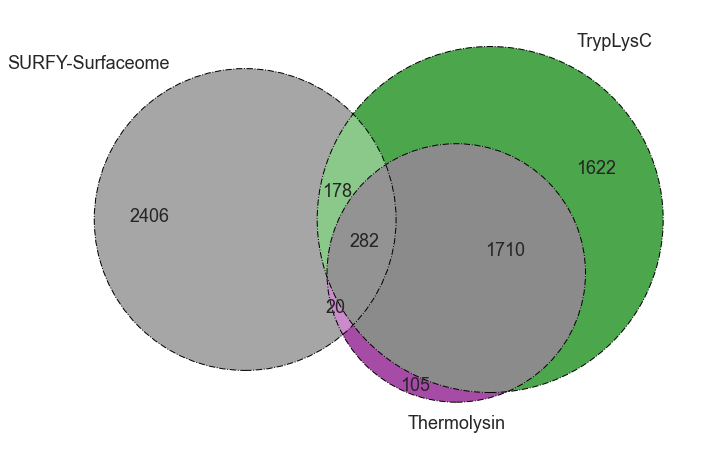

In [76]:
x=set(surface)
x2=set(TrypLysC.Protein)
x3=set(Thermo.Protein)
plt.figure(figsize=(12,8))
vd2=venn3([x, x2,x3],set_labels=('SURFY-Surfaceome',"TrypLysC", 'Thermolysin'),set_colors=('grey', 'green','purple'), alpha = 0.7)
venn3_circles([x,x2,x3], linestyle='-.', linewidth=1, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
# plt.title('OV90 Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=15,backgroundcolor='#ffffff',color='black',style='italic');
plt.savefig("SurfyvsTrypLysCvsThermolysin.eps",dpi=dpi)
plt.show()

In [77]:
Chef.Marinate(surface_df,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True,Peptide_Inspector=False)
surface_df["Length"]=surface_df['Peptide'].astype(str).map(len)
surface_df["Mass"]=surface_df['Peptide'].astype(str).map(Mass)
surface_df["z"]=surface_df["Peptide"].apply(lambda x: electrochem.charge(x,pH=2.0))
surface_df["MZ"]=surface_df['Mass']/surface_df['z']
surface_df.head()

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Protein,Peptide,IPC,Hydro_Sum,Neutral_Z,Length,Mass,z,MZ
0,O43869,MWQEYYFLNVFFPLLKVCCLTINSHVVILLPWECYHLIWKILPYIG...,8.302041,0.623035,7.0,369,41946.463759,35.432399,1183.844874
1,P11230,MTPGALLMLLGALGAPLAPGVRGSEAEGRLREKLFSGYDSSVRPAR...,5.448311,0.016567,-13.0,501,56634.671828,57.871513,978.627815
2,P52797,MAAAPLLLLLLLVPVPLLPLLAQGPGGALGNRHAVYWNSSNQHLRR...,8.682393,-0.229412,5.0,238,26311.242819,31.552402,833.890336
3,P98164,MDRGPAAVACTLLLALVACLAPASGQECDSAHFRCGSGHCIPADWR...,4.761709,-0.470784,-243.0,4655,521516.895939,535.422982,974.027850
4,Q13224,MKPRAECCSPKFWLVLAVLAVSGSRARSQKSPPSIGIAVILVGTSD...,6.490928,-0.388342,-11.0,1484,166208.803368,204.219728,813.872416


#### Trypsin in Silco Digestion

In [78]:
missed_sites=[0,1,2,3,4,5]
enzyme="trypsin"
Tryp_Peptides=[]
for site in missed_sites:
    x=f"Tryp_{site}_dig"
    z=Chef.ButcherShop(surface_df,target="Peptide",identifier="Protein", rule=enzyme,min_charge=1.55,missed=site,exception=None,min_length=7,max_length=65)
    globals()[str(x)]=Chef.Deli(z,meat_package=True)
    Tryp_Peptides.append(globals()[str(x)])

You order is being processed and the butcher is preparing your trypsin-cut protein(s)!
The butcher is working...
Generating trypsin-cut peptides based on 0-missed cleavages. 
Preparing your order...
Order is up! You have acquired 76011 peptides that are between 7 and 65 amino acids!
You order is being processed and the butcher is preparing your trypsin-cut protein(s)!
The butcher is working...
Generating trypsin-cut peptides based on 1-missed cleavages. 
Preparing your order...
Order is up! You have acquired 194534 peptides that are between 7 and 65 amino acids!
You order is being processed and the butcher is preparing your trypsin-cut protein(s)!
The butcher is working...
Generating trypsin-cut peptides based on 2-missed cleavages. 
Preparing your order...
Order is up! You have acquired 316925 peptides that are between 7 and 65 amino acids!
You order is being processed and the butcher is preparing your trypsin-cut protein(s)!
The butcher is working...
Generating trypsin-cut peptides b

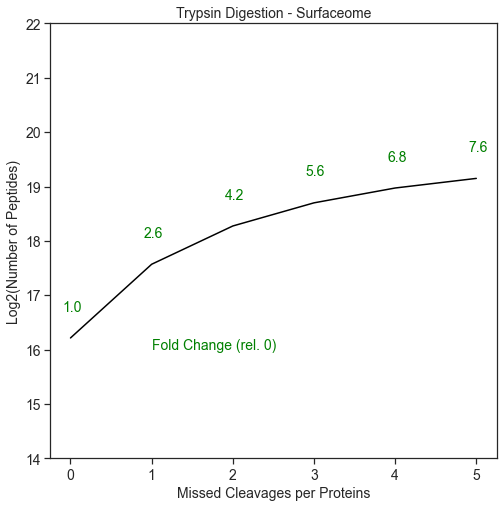

In [79]:
T_Pep_Counts=[]
#Count are in Log10
for df in Tryp_Peptides:
    log = math.log2(len(df))
    T_Pep_Counts.append(log)
plt.plot(missed_sites,T_Pep_Counts,color="black")
plt.title('Trypsin Digestion - Surfaceome',fontsize=14)
plt.xlabel('Missed Cleavages per Proteins', fontsize=14)
plt.ylabel('Log2(Number of Peptides)', fontsize=14)
plt.xticks(missed_sites,fontsize=14)
plt.yticks(np.arange(14, 26, 1),fontsize=14)
plt.ylim([14, 22])
Ratios=[]
for count in T_Pep_Counts:
    ratio=2**(count-T_Pep_Counts[0])
    ratiox=float(round(ratio,1))
    Ratios.append(ratiox)
for x_, y_, name in zip(missed_sites,T_Pep_Counts, Ratios):
    plt.text(x_-0.1,y_ + 0.5, name , fontsize=14, color="green")
plt.text(1,16,"Fold Change (rel. 0)",color="green",fontsize=14)
plt.savefig("Trypsin_Surfaceome_Peptides.eps",dpi=1200)
plt.show()

In [80]:
Trypsin_Missed_Count=[]
Trypsin_Missed={}
i=0
for df in Tryp_Peptides: 
    Marked = set(df.gene)
    Total= set(surface_df.Protein)
    unique= list(Marked ^ Total)
    x=len(unique)
    Trypsin_Missed_Count.append(x)
    Trypsin_Missed[i]=unique
    i=+1
Trypsin_Missed_Count

[0, 0, 0, 0, 0, 0]

The number of proteins with > 1 peptides : 2787.0
Ratio of Proteins with > 1 Peptides Identified: 99.928
The number of proteins with > 1 peptides : 2788.0
Ratio of Proteins with > 1 Peptides Identified: 99.964
The number of proteins with > 1 peptides : 2788.0
Ratio of Proteins with > 1 Peptides Identified: 99.964
The number of proteins with > 1 peptides : 2788.0
Ratio of Proteins with > 1 Peptides Identified: 99.964
The number of proteins with > 1 peptides : 2788.0
Ratio of Proteins with > 1 Peptides Identified: 99.964
The number of proteins with > 1 peptides : 2788.0
Ratio of Proteins with > 1 Peptides Identified: 99.964


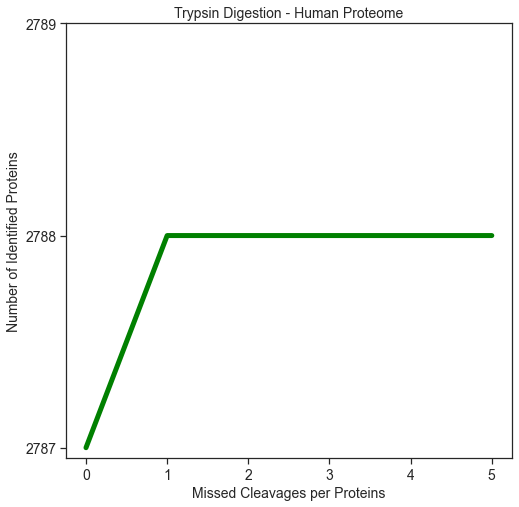

In [81]:
T_Pro_Counts=[]
xx=[]
#Count are in Log10
for df in Tryp_Peptides:
    x,y,z=Chef.Wishbone(df,"gene",1)
    T_Pro_Counts.append(y)
    xx.append(x)
plt.plot(missed_sites,T_Pro_Counts,color="green",linewidth=5)
plt.title('Trypsin Digestion - Human Proteome',fontsize=14)
plt.xlabel('Missed Cleavages per Proteins', fontsize=14)
plt.ylabel('Number of Identified Proteins', fontsize=14)
plt.xticks(missed_sites,fontsize=14)
plt.yticks(np.arange(T_Pro_Counts[0], T_Pro_Counts[-1]+2, 1),fontsize=14)
plt.savefig("Trypsin_Silico_Protein_m1.eps",dpi=600,bbox_inches='tight')
plt.show()

In [82]:
# i=0
# columns=["0","1","2","3","4","5"]
# Trypsin_Coverage=[]
# Tryp_Silico_Coverage=pd.DataFrame()
# for df in Tryp_Peptides:
#     name=f"Cov_{columns[i]}" 
#     globals()[str(name)]={}
#     for gene, protein in raw_surface.items():
#         temp=tuple(df.loc[df.gene == gene]["peptide"])
#         x=Chef.Pep2Pro(protein,temp)
#         globals()[str(name)][gene]=x
#     temp=list(globals()[str(name)].values())
#     Tryp_Silico_Coverage[name]= np.array(temp)
#     i+=1
#     print("Segment Complete...")
# print("Collection Finished.")

In [83]:
# Tryp_Silico_Coverage.to_excel('Silico_Trypsin_Coverage_raw.xlsx')

In [84]:
Tryp_Silico_Coverage=pd.read_excel(r'Silico_Trypsin_Coverage_raw.xlsx')

In [85]:
Tryp_Silico_Coverage.describe()

,Unnamed: 0,Cov_0,Cov_1,Cov_2,Cov_3,Cov_4,Cov_5
count,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000
mean,1394.000000,0.817233,0.934511,0.944416,0.945364,0.945451,0.945455
std,805.259275,0.103831,0.108011,0.107648,0.107560,0.107529,0.107531
min,0.000000,0.137809,0.155477,0.155477,0.155477,0.155477,0.155477
25%,697.000000,0.777424,0.919295,0.929761,0.930262,0.930502,0.930502
50%,1394.000000,0.845098,0.986316,1.000000,1.000000,1.000000,1.000000
75%,2091.000000,0.886768,0.996032,1.000000,1.000000,1.000000,1.000000
max,2788.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


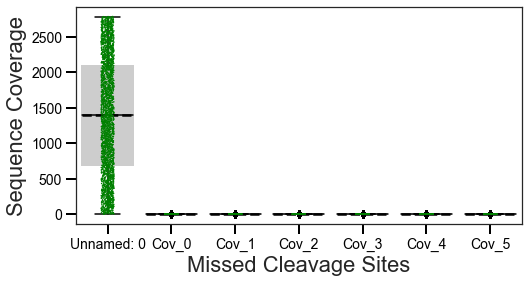

In [86]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='black')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=Tryp_Silico_Coverage,color='green',s=1.5)
sns.boxplot(data=Tryp_Silico_Coverage,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=True,color="black",linewidth=1.5)
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Sequence Coverage",fontsize=22)
plt.xlabel("Missed Cleavage Sites",fontsize=22)
plt.xticks(fontsize=14,rotation=0)
plt.yticks(fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('TrypLysC_Surfaceome_SC.eps',dpi=dpi,bbox_inches="tight")
plt.show()

#### Thermolysin in Silco Digestion

In [87]:
missed_sites=[0,1,2,3,4,5]
enzyme="thermolysin"
Thermo_Peptides=[]
for site in missed_sites:
    x=f"Thermolysin_{site}_dig"
    z=Chef.ButcherShop(surface_df,target="Peptide",identifier="Protein", rule=enzyme,min_charge=1.55,missed=site,exception=None,min_length=7,max_length=65)
    globals()[str(x)]=Chef.Deli(z,meat_package=True)
    Thermo_Peptides.append(globals()[str(x)])

You order is being processed and the butcher is preparing your thermolysin-cut protein(s)!
The butcher is working...
Generating thermolysin-cut peptides based on 0-missed cleavages. 
Preparing your order...
Order is up! You have acquired 43403 peptides that are between 7 and 65 amino acids!
You order is being processed and the butcher is preparing your thermolysin-cut protein(s)!
The butcher is working...
Generating thermolysin-cut peptides based on 1-missed cleavages. 
Preparing your order...
Order is up! You have acquired 184635 peptides that are between 7 and 65 amino acids!
You order is being processed and the butcher is preparing your thermolysin-cut protein(s)!
The butcher is working...
Generating thermolysin-cut peptides based on 2-missed cleavages. 
Preparing your order...
Order is up! You have acquired 435120 peptides that are between 7 and 65 amino acids!
You order is being processed and the butcher is preparing your thermolysin-cut protein(s)!
The butcher is working...
Gener

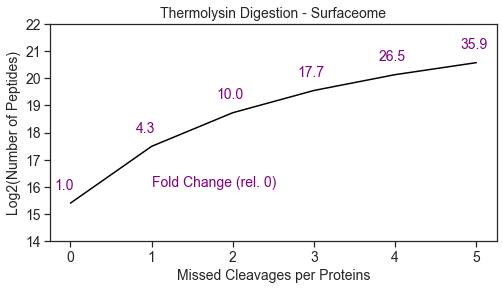

In [88]:
TH_Pep_Counts=[]
#Count are in Log10
for df in Thermo_Peptides:
    log = math.log2(len(df))
    TH_Pep_Counts.append(log)
plt.plot(missed_sites,TH_Pep_Counts,color="black")
plt.title('Thermolysin Digestion - Surfaceome',fontsize=14)
plt.xlabel('Missed Cleavages per Proteins', fontsize=14)
plt.ylabel('Log2(Number of Peptides)', fontsize=14)
plt.xticks(missed_sites,fontsize=14)
plt.yticks(np.arange(14, 26, 1),fontsize=14)
plt.ylim([14, 22])
Ratios=[]
for count in TH_Pep_Counts:
    ratio=2**(count-TH_Pep_Counts[0])
    ratiox=float(round(ratio,1))
    Ratios.append(ratiox)
for x_, y_, name in zip(missed_sites,TH_Pep_Counts, Ratios):
    plt.text(x_-0.2,y_ + 0.5, name , fontsize=14, color="purple")
plt.text(1,16,"Fold Change (rel. 0)",color="purple",fontsize=14)
plt.savefig("Thermolysin_Surfaceome_Peptides.eps",dpi=1200)
plt.show()

In [89]:
Thermolysin_Missed_Count=[]
Thermolysin_Missed={}
i=0
for df in Thermo_Peptides: 
    Marked = set(df.gene)
    Total= set(surface_df.Protein)
    unique= list(Marked ^ Total)
    x=len(unique)
    Thermolysin_Missed_Count.append(x)
    Thermolysin_Missed[i]=unique
    i=+1
Thermolysin_Missed_Count

[9, 1, 1, 0, 0, 0]

The number of proteins with > 1 peptides : 2749.0
Ratio of Proteins with > 1 Peptides Identified: 98.885
The number of proteins with > 1 peptides : 2787.0
Ratio of Proteins with > 1 Peptides Identified: 99.964
The number of proteins with > 1 peptides : 2788.0
Ratio of Proteins with > 1 Peptides Identified: 100.000
The number of proteins with > 1 peptides : 2788.0
Ratio of Proteins with > 1 Peptides Identified: 99.964
The number of proteins with > 1 peptides : 2789.0
Ratio of Proteins with > 1 Peptides Identified: 100.000
The number of proteins with > 1 peptides : 2789.0
Ratio of Proteins with > 1 Peptides Identified: 100.000


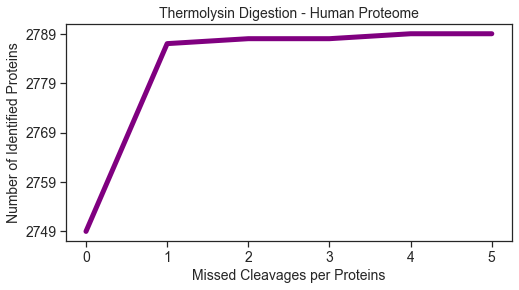

In [90]:
TH_Pro_Counts=[]
xx=[]
#Count are in Log10
for df in Thermo_Peptides:
    x,y,z=Chef.Wishbone(df,"gene",1)
    TH_Pro_Counts.append(y)
    xx.append(x)
plt.plot(missed_sites,TH_Pro_Counts,color="purple",linewidth=5)
plt.title('Thermolysin Digestion - Human Proteome',fontsize=14)
plt.xlabel('Missed Cleavages per Proteins', fontsize=14)
plt.ylabel('Number of Identified Proteins', fontsize=14)
plt.xticks(missed_sites,fontsize=14)
plt.yticks(np.arange(2749,2790, 10),fontsize=14)
plt.savefig("Thermolysin_Silico_Protein_m1.eps",dpi=600,bbox_inches='tight')
plt.show()

In [91]:
# i=0
# columns=["0","1","2","3","4","5"]
# Thermo_Coverage=[]
# Thermolysin_Silico_Coverage=pd.DataFrame()
# for df in Thermo_Peptides:
#     name=f"Cov_{columns[i]}" 
#     globals()[str(name)]={}
#     for gene, protein in raw_surface.items():
#         temp=tuple(df.loc[df.gene == gene]["peptide"])
#         x=Chef.Pep2Pro(protein,temp)
#         globals()[str(name)][gene]=x
#     temp=list(globals()[str(name)].values())
#     Thermolysin_Silico_Coverage[name]= np.array(temp)
#     i+=1
#     print("Segment Complete...")
# print("Collection Finished.")

In [92]:
# Thermolysin_Silico_Coverage.to_excel('Silico_Thermolysin_Coverage_raw.xlsx')

In [93]:
Thermolysin_Silico_Coverage=pd.read_excel(r'Silico_Thermolysin_Coverage_raw.xlsx')

In [94]:
Thermolysin_Silico_Coverage.describe()

,Unnamed: 0,Cov_0,Cov_1,Cov_2,Cov_3,Cov_4,Cov_5
count,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000
mean,1394.000000,0.227566,0.517811,0.707728,0.808217,0.864602,0.903225
std,805.259275,0.103843,0.144333,0.135011,0.112269,0.092696,0.075610
min,0.000000,0.000000,0.000000,0.000000,0.114754,0.311475,0.344262
25%,697.000000,0.149378,0.396694,0.589820,0.716253,0.796296,0.854938
50%,1394.000000,0.226244,0.533751,0.731049,0.829126,0.884354,0.921036
75%,2091.000000,0.299003,0.632780,0.823852,0.905473,0.944464,0.965066
max,2788.000000,0.750572,0.906178,0.964179,0.997015,1.000000,1.000000


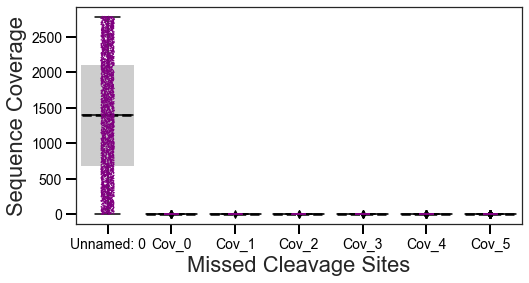

In [95]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='black')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=Thermolysin_Silico_Coverage,color='purple',s=1.5)
sns.boxplot(data=Thermolysin_Silico_Coverage,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=True,color="black",linewidth=1.5)
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Sequence Coverage",fontsize=22)
plt.xlabel("Missed Cleavage Sites",fontsize=22)
plt.xticks(fontsize=14,rotation=0)
plt.yticks(fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('Thermolysin_Surfaceome_SC.eps',dpi=dpi,bbox_inches="tight")
plt.show()

## In Silico Digestion of CD9, max=5 missed cleavages. 

In [96]:
CD9="MPVKGGTKCIKYLLFGFNFIFWLAGIAVLAIGLWLRFDSQTKSIFEQETNNNNSSFYTGVYILIGAGALMMLVGFLGCCGAVQESQCMLGLFFGFLLVIFAIEIAAAIWGYSHKDEVIKEVQEFYKDTYNKLKTKDEPQRETLKAIHYALNCCGLAGGVEQFISDICPKKDVLETFTVKSCPDAIKEVFDNKFHIIGAVGIGIAVVMIFGMIFSMILCCAIRRNREMV"

In [97]:
TrypLysC_CD9=Chef.Cleaver(CD9,"trypsin",missed_cleavages=5,min_length=7, max_length=65)
print(len(TrypLysC_CD9))
x=Chef.Pep2Pro(CD9,tuple(TrypLysC_CD9))
print(x*100)

76
68.42105263157895


In [98]:
Thermolysin_CD9=Chef.Cleaver(CD9,"thermolysin",missed_cleavages=5,min_length=7, max_length=65)
print(len(Thermolysin_CD9))
x=Chef.Pep2Pro(CD9,tuple(Thermolysin_CD9))
print(x*100)

260
100.0


In [99]:
mc=[0,1,2,3,4,5]
ez=["trypsin","thermolysin"]
ml=[3,4,5,6,7]
peptide_number=[]
sequence_coverage=[]
missed_cleavages=[]
enzymes=[]
lengths=[]
i=0
for enzyme in ez:
    for site in mc:
        for length in ml:
            enzymes.append(enzyme)
            missed_cleavages.append(int(site))
            lengths.append(length)
            x=Chef.Cleaver(CD9,enzyme,missed_cleavages=site,min_length=length, max_length=65)
            peptide_number.append(len(x))
            y=Chef.Pep2Pro(CD9,tuple(x))
            sequence_coverage.append(y*100)
            
CD9_Digest=pd.DataFrame({'Enzyme':enzymes,
                        "Peptide_Number":peptide_number,
                        "Missed_Cleavages":missed_cleavages,
                        "Sequence_Coverage":sequence_coverage,
                        "Min_Length":lengths})

CD9_Digest['Enzyme'] = CD9_Digest['Enzyme'].str.replace('trypsin','TrypLysC')
CD9_Digest['Enzyme'] = CD9_Digest['Enzyme'].str.replace('thermolysin','Thermolysin')
CD9_Digest.head()

,Enzyme,Peptide_Number,Missed_Cleavages,Sequence_Coverage,Min_Length
0,TrypLysC,16,0,64.912281,3
1,TrypLysC,14,0,62.280702,4
2,TrypLysC,11,0,57.017544,5
3,TrypLysC,8,0,50.438596,6
4,TrypLysC,6,0,45.175439,7


<Figure size 576x576 with 0 Axes>

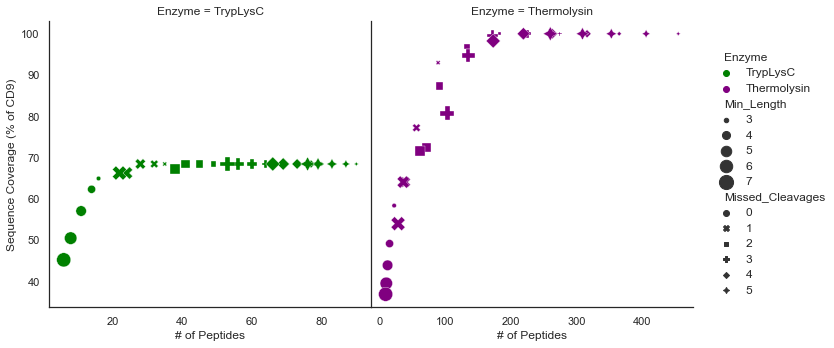

In [100]:
plt.figure(figsize=(8,8))
# sns.lineplot(x="Peptide_Number", y="Sequence_Coverage",linewidth = 3,
#              hue="Enzyme", style="Missed_Cleavages",
#              data=CD9_Digest,palette=colors3)

# sns.lmplot(x="Peptide_Number", y="Sequence_Coverage", col="Enzyme", hue="Missed_Cleavages", data=CD9_Digest,
#            col_wrap=2, ci=None, palette="muted", height=4,
#            scatter_kws={"s": 50, "alpha": 1})

# g=sns.relplot(
#     data=CD9_Digest,
#     x="Peptide_Number", y="Sequence_Coverage",
#     hue="Enzyme", size="Missed_Cleavages", col="Enzyme",
#     kind="line", size_order=["trypsin", "thermolysin"], palette=colors3,
#     height=5, aspect=.75, facet_kws=dict(sharex=False),
# )
sns.set_style("white")
g=sns.relplot(
    data=CD9_Digest, x="Peptide_Number", y="Sequence_Coverage", col="Enzyme",
    hue="Enzyme", size="Min_Length", style="Missed_Cleavages",
    palette=colors, sizes=(20, 200), alpha=1,facet_kws=dict(sharex=False)
)

(g.set_axis_labels("# of Peptides", "Sequence Coverage (% of CD9)", fontsize=12)
  .tight_layout(w_pad=0))
# plt.ylabel("Sequence Coverage (% of CD9)",fontsize=18)
# plt.xlabel("# of Peptides",fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
plt.savefig("CD9_Digest.eps",dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


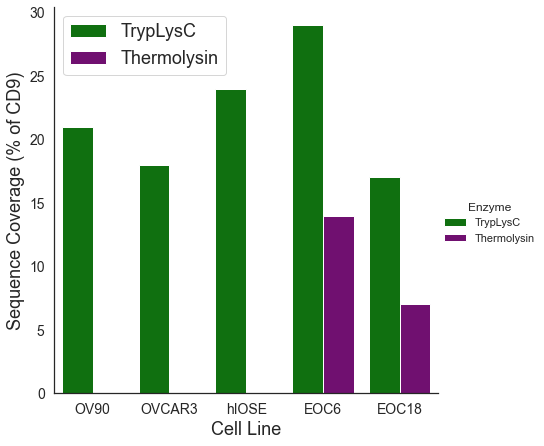

In [101]:
CD9_real=pd.DataFrame({'Enzyme':["TrypLysC","TrypLysC","TrypLysC","TrypLysC","TrypLysC","Thermolysin","Thermolysin","Thermolysin","Thermolysin","Thermolysin"],
                        "Cells":["OV90","OVCAR3","hIOSE","EOC6","EOC18","OV90","OVCAR3","hIOSE","EOC6","EOC18"],
                        "CD9":[21,18,24,29,17,0,0,0,14,7]})

sns.set_style("white")
sns.catplot(
    data=CD9_real, kind="bar",
    x="Cells", y="CD9", hue="Enzyme", palette=colors, alpha=1, height=6
)

plt.ylabel("Sequence Coverage (% of CD9)",fontsize=18)
plt.xlabel("Cell Line", fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=18)
plt.savefig("CD9_real.eps",dpi=600,bbox_inches="tight")

In [102]:
CD9_df1=pd.DataFrame({'Peptide': pd.Series(TrypLysC_CD9)})
CD9_df1['ID'] = np.resize("TrypLysC",len(CD9_df1))
CD9_df2=pd.DataFrame({'Peptide': pd.Series(Thermolysin_CD9)})
CD9_df2['ID'] = np.resize("Thermolysin",len(CD9_df2))
CD9_df=pd.concat([CD9_df1,CD9_df2],ignore_index=True)
Chef.Marinate(CD9_df,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True,Peptide_Inspector=False)
CD9_df
CD9_df["Length"]=CD9_df['Peptide'].astype(str).map(len)
CD9_df["Mass"]=CD9_df['Peptide'].astype(str).map(Mass)
CD9_df["z"]=CD9_df["Peptide"].apply(lambda x: electrochem.charge(x,pH=2.0))
CD9_df["MZ"]=CD9_df['Mass']/CD9_df['z']
CD9_df=CD9_df.loc[(CD9_df.z >= 1.55)]
CD9_df.describe()

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,IPC,Hydro_Sum,Neutral_Z,Length,Mass,z,MZ
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,7.222360,-0.236852,0.172093,21.339535,2428.258677,4.048783,618.041325
std,2.224555,1.029293,1.388593,12.389363,1383.902277,2.006278,266.577749
min,3.884385,-3.028571,-2.000000,7.000000,673.358132,1.653219,250.663827
25%,5.251230,-1.011111,-1.000000,11.500000,1304.731167,2.653219,443.251765
50%,7.000068,-0.150000,0.000000,17.000000,1920.976770,3.658711,550.026453
75%,9.340693,0.357428,1.000000,29.500000,3285.812911,5.136913,747.864000
max,12.207959,2.226667,4.000000,55.000000,6080.203731,10.592449,1823.325570


In [103]:
Chef.Marinate(CD9_df2,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True,Peptide_Inspector=False)
CD9_df2["z"]=CD9_df2["Peptide"].apply(lambda x: electrochem.charge(x,pH=2.0))
CD9_slice=CD9_df2.loc[(CD9_df2.z >= 1.55)]
CD9_df2.describe()


Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,IPC,Hydro_Sum,Neutral_Z,z
count,260.000000,260.000000,260.000000,260.000000
mean,6.129821,0.531427,-0.150000,2.305470
std,2.236672,1.353175,1.113536,2.147084
min,3.185068,-2.318182,-2.000000,0.675116
25%,4.450195,-0.395060,-1.000000,0.686300
50%,5.969619,0.327619,0.000000,1.672505
75%,7.259731,1.825893,0.000000,3.610822
max,12.207959,3.071429,3.000000,10.592449


In [104]:
x=Chef.Pep2Pro(CD9,tuple(CD9_slice.Peptide))
print(x)

0.7543859649122807


In [105]:
Chef.Marinate(CD9_df1,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True,Peptide_Inspector=False)
CD9_df1["z"]=CD9_df1["Peptide"].apply(lambda x: electrochem.charge(x,pH=2.0))
CD9_slice1=CD9_df1.loc[(CD9_df1.z >= 1.55)]

Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


In [106]:
x=Chef.Pep2Pro(CD9,tuple(set(CD9_slice1.Peptide)|set(CD9_slice.Peptide)))
print(x)

0.8333333333333334


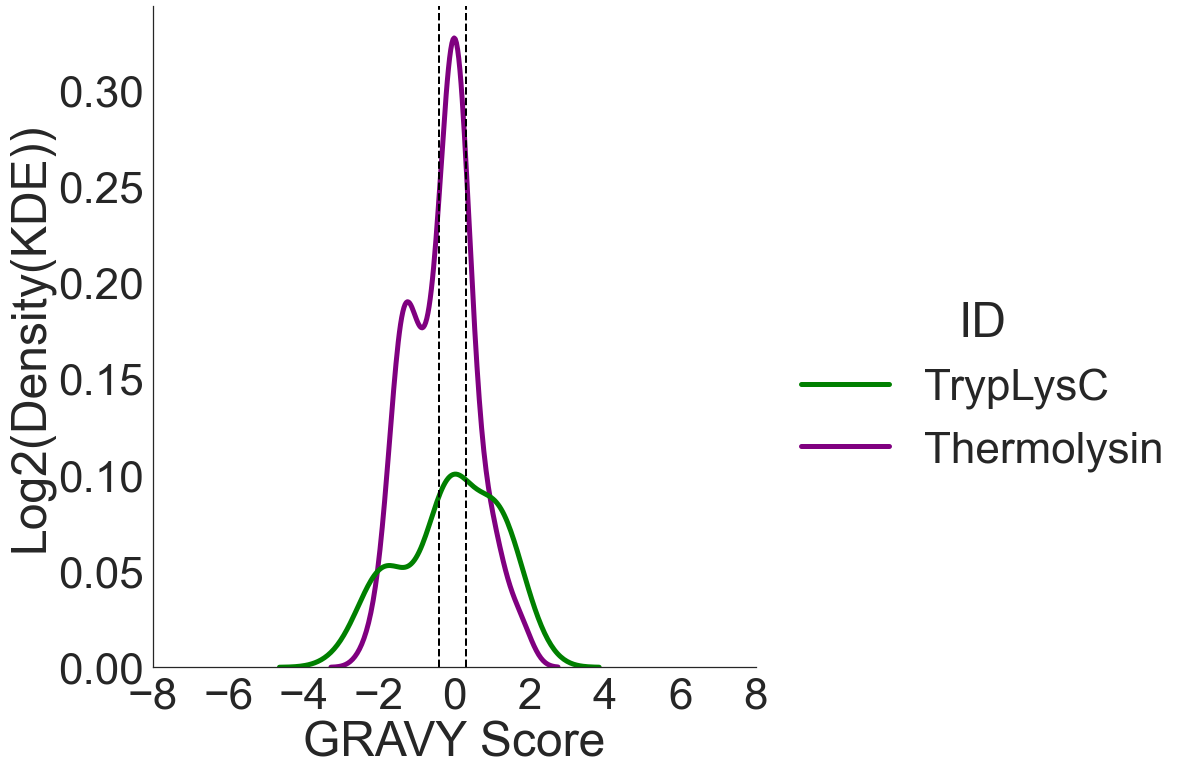

In [107]:
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=CD9_df,
    x="Hydro_Sum", hue="ID",
    kind="kde", height=12,log_scale=(0,0),palette=colors,linewidth=5  
)
plt.xticks(np.arange(-8,8.1,2))
plt.xlabel('GRAVY Score', fontsize=48)
plt.ylabel('Log2(Density(KDE))', fontsize=48)
plt.axvline(x=0.3, linestyle="--",color='black',linewidth=2)
plt.axvline(x=-0.4, linestyle="--",color='black',linewidth=2)
g.savefig("CD9_GRAVY.eps")

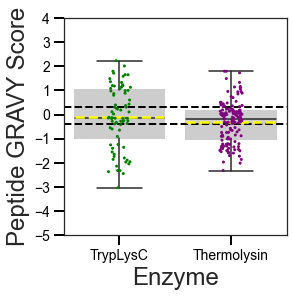

In [108]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(x="ID", y="Hydro_Sum",palette=colors,data=CD9_df,s=3)
sns.boxplot(x="ID", y="Hydro_Sum",palette=colors,data=CD9_df,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide GRAVY Score",fontsize=24)
plt.xlabel("Enzyme",fontsize=24)
plt.xticks(fontsize=14,rotation=0)
plt.yticks(np.arange(-5,5,1),fontsize=14)
plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('CD9_GRAVY_Swarm',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

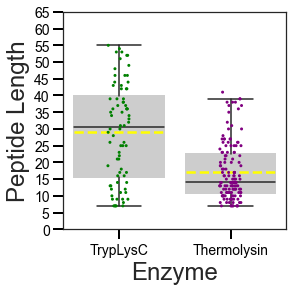

In [109]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(x="ID", y="Length",palette=colors,data=CD9_df,s=3)
sns.boxplot(x="ID", y="Length",palette=colors,data=CD9_df,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide Length",fontsize=24)
plt.xlabel("Enzyme",fontsize=24)
plt.xticks(fontsize=14,rotation=0)
plt.yticks(np.arange(0,66,5),fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('CD9_Length',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

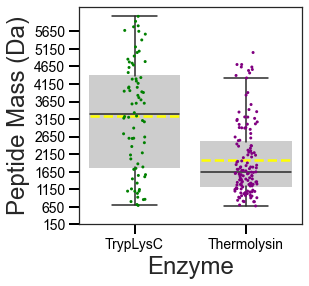

In [110]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(x="ID", y="Mass",palette=colors,data=CD9_df,s=3)
sns.boxplot(x="ID", y="Mass",palette=colors,data=CD9_df,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide Mass (Da)",fontsize=24)
plt.xlabel("Enzyme",fontsize=24)
plt.xticks(fontsize=14,rotation=0)
plt.yticks(np.arange(150,6101,500),fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('CD9_Mass',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

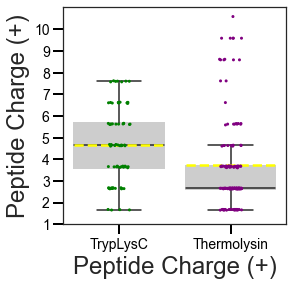

In [111]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(x="ID", y="z",palette=colors,data=CD9_df,s=3)
sns.boxplot(x="ID", y="z",palette=colors,data=CD9_df,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide Charge (+)",fontsize=24)
plt.xlabel("Peptide Charge (+)",fontsize=24)
plt.xticks(fontsize=14,rotation=0)
plt.yticks(np.arange(1,11,1),fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('CD9_z',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

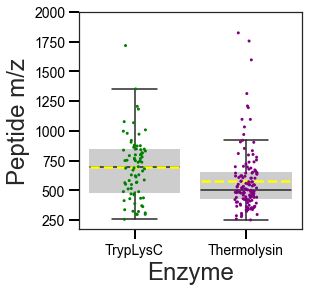

In [112]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(x="ID", y="MZ",palette=colors,data=CD9_df,s=3)
sns.boxplot(x="ID", y="MZ",palette=colors,data=CD9_df,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide m/z",fontsize=24)
plt.xlabel("Enzyme",fontsize=24)
plt.xticks(fontsize=14,rotation=0)
plt.yticks(np.arange(250,2001,250),fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('CD9_z',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

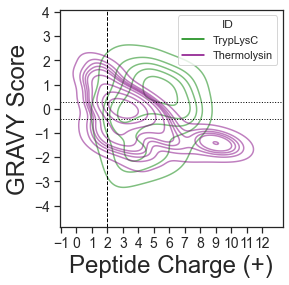

In [113]:
plt.figure(figsize=(4,4))
sns.kdeplot(
    data=CD9_df, x="z", y="Hydro_Sum", hue="ID", fill=False,alpha=0.5,palette=colors
)
plt.ylabel("GRAVY Score",fontsize=24)
plt.xlabel("Peptide Charge (+)",fontsize=24)
plt.xticks(np.arange(-1,13,1),fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=2, linestyle="--",color='black',linewidth=1)
plt.axhline(y=0.3, linestyle=":",color='black',linewidth=1)
plt.axhline(y=-0.4, linestyle=":",color='black',linewidth=1)
plt.savefig("Gravy vs Z.eps",dpi=1200,bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

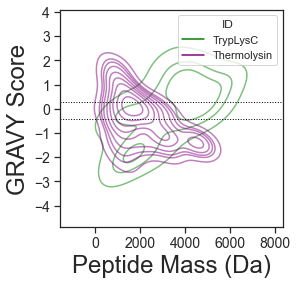

In [114]:
plt.figure(figsize=(4,4))
sns.kdeplot(
    data=CD9_df, x="Mass", y="Hydro_Sum", hue="ID", fill=False,alpha=0.5,palette=colors
)
plt.ylabel("GRAVY Score",fontsize=24)
plt.xlabel("Peptide Mass (Da)",fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(y=0.3, linestyle=":",color='black',linewidth=1)
plt.axhline(y=-0.4, linestyle=":",color='black',linewidth=1)
plt.savefig("Gravy vs Mass.eps",dpi=1200,bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

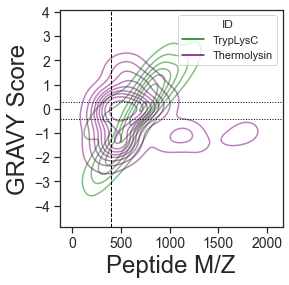

In [115]:
plt.figure(figsize=(4,4))
sns.kdeplot(
    data=CD9_df, x="MZ", y="Hydro_Sum", hue="ID", fill=False,alpha=0.5,palette=colors
)
plt.ylabel("GRAVY Score",fontsize=24)
plt.xlabel("Peptide M/Z",fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=400, linestyle="--",color='black',linewidth=1)
plt.axhline(y=0.3, linestyle=":",color='black',linewidth=1)
plt.axhline(y=-0.4, linestyle=":",color='black',linewidth=1)
plt.savefig("Gravy vs MZ.eps",dpi=1200,bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

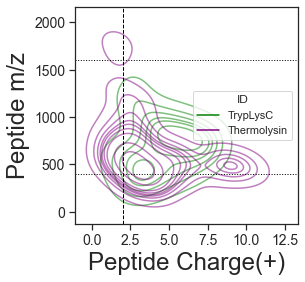

In [116]:
plt.figure(figsize=(4,4))
sns.kdeplot(
    data=CD9_df, x="z", y="MZ", hue="ID", fill=False,alpha=0.5,palette=colors
)
plt.ylabel("Peptide m/z",fontsize=24)
plt.xlabel("Peptide Charge(+)",fontsize=24)
plt.axhline(y=400, linestyle=":",color='black',linewidth=1)
plt.axhline(y=1600, linestyle=":",color='black',linewidth=1)
plt.axvline(x=2, linestyle="--",color='black',linewidth=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("Charge vs z.eps",dpi=1200,bbox_inches="tight")

In [117]:
# x=raw.loc[raw["Gene"]=="CD9"].describe()
# # Chef.Marinate(x,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True,Peptide_Inspector=False)
# x

In [118]:

OV90_TrypLysC.loc[OV90_TrypLysC["Gene"]=="CD9"]

,Area OV90_TrypLysC,#Feature OV90_TrypLysC,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
12075,268150000.0,6,1702,P21926,AIHYALNCCGLAGGVEQFISDICPKK,CD9,2792.3083,51.19,99.9,1397.1626,2,25,6.897666,0.426923,0.0
12076,10601000.0,1,1702,P21926,AIHYALNCCGLAGGVEQFISDICPKK,CD9,2793.2925,51.85,99.9,932.1053,3,25,6.897666,0.426923,0.0
12077,205900000.0,1,1702,P21926,KDVLETFTVKS,CD9,1178.6547,37.31,99.9,590.3344,2,10,6.970811,-0.181818,0.0
12078,35209000.0,2,1702,P21926,DVLETFTVKS,CD9,1050.5597,41.31,99.9,1051.5659,1,9,4.113252,0.190000,-1.0
12079,440170000.0,2,1702,P21926,EVQEFYKD,CD9,941.4494,26.52,99.5,471.7324,2,7,3.884385,-1.525000,-2.0


## De Novo Analysis

In [119]:
denovo = pd.read_csv("de novo only peptides.csv")
denovo.describe()

,Fraction,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Area,Mass,ppm
count,153387.000000,153387.000000,153387.000000,153387.000000,153387.000000,153387.000000,153387.000000,153387.000000,1.533870e+05,153387.000000,153387.000000
mean,15.420877,11.269521,71.535873,71.535873,11.269521,615.506491,2.047696,37.997309,4.731029e+07,1265.674327,0.614126
std,9.967281,5.267157,14.948501,14.948501,5.267157,163.704941,0.697434,13.551468,4.206111e+08,582.597598,7.861277
min,1.000000,3.000000,50.000000,50.000000,3.000000,399.958900,1.000000,3.420000,0.000000e+00,399.146400,-20.100000
25%,4.000000,8.000000,58.000000,58.000000,8.000000,489.754800,2.000000,29.080000,6.561750e+05,859.443900,-1.600000
50%,14.000000,10.000000,69.000000,69.000000,10.000000,584.979400,2.000000,36.060000,2.893800e+06,1172.574700,0.200000
75%,23.000000,14.000000,84.000000,84.000000,14.000000,705.375550,2.000000,44.070000,1.069700e+07,1534.814200,3.300000
max,33.000000,45.000000,99.000000,99.000000,45.000000,1492.261200,7.000000,136.270000,2.438800e+10,5557.792000,20.000000


In [120]:
denovo=denovo.loc[denovo['length'] >= 5]

### Thermolysin De Novo

In [121]:
thermo_denovo=denovo.loc[denovo["Source File"].str.contains('Thermolysin')]

In [122]:
len(thermo_denovo)

61767

In [123]:
thermo_denovo["Peptide"]= thermo_denovo.loc[:,"Peptide"].str.replace('\W+|\d+',"")
acid=["F","M","V","A","I","L"]
thermo_denovo["Peptide"]= thermo_denovo.loc[:,"Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)
thermo_80=thermo_denovo.loc[thermo_denovo['ALC (%)'] >= 80]
print(len(thermo_80))
print(len(thermo_denovo)-len(thermo_80))

13887
47880


<ipython-input-123-231f2f633c78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thermo_denovo["Peptide"]= thermo_denovo.loc[:,"Peptide"].str.replace('\W+|\d+',"")
<ipython-input-123-231f2f633c78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thermo_denovo["Peptide"]= thermo_denovo.loc[:,"Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)


In [124]:
thermo_80.describe()

,Fraction,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Area,Mass,ppm
count,13887.000000,13887.000000,13887.000000,13887.000000,13887.000000,13887.000000,13887.000000,13887.000000,1.388700e+04,13887.000000,13887.000000
mean,14.768993,7.931375,89.897386,89.897386,7.931375,583.292330,1.600706,32.758077,6.584484e+07,904.624524,0.543220
std,9.915163,2.974150,6.204592,6.204592,2.974150,112.848022,0.588851,8.262778,5.384860e+08,322.232325,4.409399
min,1.000000,5.000000,80.000000,80.000000,5.000000,400.181200,1.000000,3.580000,0.000000e+00,415.243100,-20.000000
25%,3.000000,5.000000,84.000000,84.000000,5.000000,491.239400,1.000000,26.630000,1.879200e+06,637.259500,-0.700000
50%,15.000000,7.000000,90.000000,90.000000,7.000000,581.803800,2.000000,31.770000,5.541000e+06,834.379300,0.100000
75%,23.000000,10.000000,96.000000,96.000000,10.000000,659.830050,2.000000,38.205000,1.829450e+07,1101.533900,0.900000
max,31.000000,25.000000,99.000000,99.000000,25.000000,1218.978300,5.000000,132.670000,1.962400e+10,2936.186500,19.900000


In [125]:
grass=thermo_denovo.loc[thermo_denovo['ALC (%)'] >= 50, 'Peptide']
grass=set(grass)
len(grass)
x=Chef.Pep2Pro(CD9,tuple(grass))
print(x*100)

27.192982456140353


In [126]:
Thermolysin
Thermolysin["Peptide"]= Thermolysin.loc[:,"Peptide"].str.replace('\W+|\d+',"")
acid=["F","M","V","A","I","L"]
Thermolysin["Peptide"]= Thermolysin.loc[:,"Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)

In [127]:
thresholds=[50,60,70,80,90]
thermo_ALC=[]
for hold in thresholds:
    grass=thermo_denovo.loc[thermo_denovo['ALC (%)'] >= hold, 'Peptide']
    trees=set(Thermolysin.Peptide)|set(grass)
    x=Chef.Pep2Pro(CD9,tuple(trees))
    thermo_ALC.append(x*100)
    print(x*100)
print(thermo_ALC)


44.73684210526316
39.91228070175439
39.03508771929825
37.280701754385966
33.771929824561404
[44.73684210526316, 39.91228070175439, 39.03508771929825, 37.280701754385966, 33.771929824561404]


### Trypsin De Novo

In [128]:
tl_denovo=denovo.loc[denovo["Source File"].str.contains('TrypLysC')]
tl_denovo.head()

,Fraction,Source File,Feature,Peptide,Scan,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Predict RT,Area,Mass,ppm,Accession,PTM,local confidence (%),tag (>=0%),mode
1,4,TC_24April2021_OVCAR3_TrypLysC_90min.raw,F4:98366,NPSNC(+57.02)YGEESDAVC(+57.02)EK,F4:4910,16,99,99,16,929.8646,2,21.37,-,8.395500e+07,1857.7146,0.1,Q6NZI2|CAVN1_HUMAN:O43633|CHM2A_HUMAN,Carbamidomethylation,100 100 100 100 100 100 100 100 100 100 100 10...,NPSNC(+57.02)YGEESDAVC(+57.02)EK,HCD
3,21,TC_01May2021_OVCAR3_TrypLysC_90min_rep2.raw,F21:58918,LGMFDLHYC(+57.02)DK,F21:15016,11,99,99,11,699.8125,2,41.25,-,1.307700e+09,1397.6108,-0.3,NaN,Carbamidomethylation,100 100 100 100 100 100 100 100 100 100 100,LGMFDLHYC(+57.02)DK,HCD
5,4,TC_24April2021_OVCAR3_TrypLysC_90min.raw,F4:104153,ALLHC(+57.02)Q(+.98)GSFVVDVLDFK,F4:20293,17,99,99,17,974.9945,2,47.28,-,2.187700e+07,1947.9763,-1.0,P00918|CAH2_HUMAN:Q01974|ROR2_HUMAN,Carbamidomethylation; Deamidation (NQ),100 100 100 100 100 100 100 100 100 100 100 10...,ALLHC(+57.02)Q(+.98)GSFVVDVLDFK,HCD
6,4,TC_24April2021_OVCAR3_TrypLysC_90min.raw,F4:87963,SPTSQQ(+.98)VMFLTLQVK,F4:54928,15,99,99,15,854.4528,2,132.41,-,2.426400e+07,1706.8914,-0.2,P08174|DAF_HUMAN:Q08174|PCDH1_HUMAN:Q12864|CAD...,Deamidation (NQ),100 100 100 100 100 100 100 100 100 100 100 10...,SPTSQQ(+.98)VMFLTLQVK,HCD
8,4,TC_24April2021_OVCAR3_TrypLysC_90min.raw,F4:59084,LGMFDLHYC(+57.02)DK,F4:16441,11,99,99,11,699.8110,2,41.02,-,2.027700e+09,1397.6108,-2.4,NaN,Carbamidomethylation,100 100 100 100 100 100 100 100 100 100 100,LGMFDLHYC(+57.02)DK,HCD


In [129]:
tl_denovo["Peptide"]= tl_denovo.loc[:,"Peptide"].str.replace('\W+|\d+',"")
acid=["K","R"]
tl_denovo["Peptide"]= tl_denovo.loc[:,"Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)
TL_80=tl_denovo.loc[tl_denovo['ALC (%)'] >= 80]
print(len(TL_80))
print(len(tl_denovo)-len(TL_80))

30925
51958


<ipython-input-129-b39e6befab9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tl_denovo["Peptide"]= tl_denovo.loc[:,"Peptide"].str.replace('\W+|\d+',"")
<ipython-input-129-b39e6befab9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tl_denovo["Peptide"]= tl_denovo.loc[:,"Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)


### De Novo Peptide IDs overtime

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


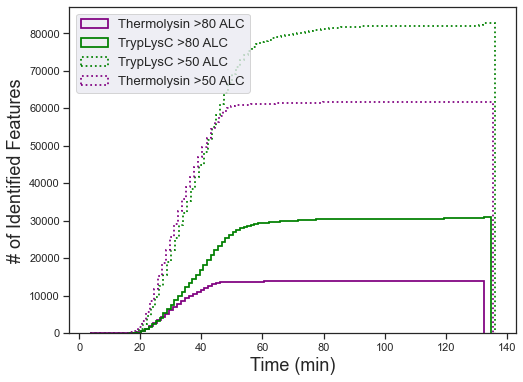

In [130]:
x = thermo_80.RT
y = TL_80.RT
z = tl_denovo.RT
w = thermo_denovo.RT
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, density=False, histtype='step',
                           cumulative=True, label='Thermolysin >80 ALC',color='purple',linewidth=1.75)

n, bins, patches = ax.hist(y, n_bins, density=False, histtype='step',
                           cumulative=True, label='TrypLysC >80 ALC',color='green',linewidth=1.75)

n, bins, patches = ax.hist(z, n_bins, density=False, histtype='step',
                           cumulative=True, label='TrypLysC >50 ALC',color='green',linestyle=':',linewidth=1.75)

n, bins, patches = ax.hist(w, n_bins, density=False, histtype='step',
                           cumulative=True, label='Thermolysin >50 ALC',color='purple',linestyle=':',linewidth=1.75)
# tidy up the figure
ax.grid(False)
ax.legend(loc='upper left')
ax.set_xlabel('Time (min)',fontsize=18)
ax.set_ylabel('# of Identified Features',fontsize=18)
plt.savefig("denovo_FeaturesvsTime.eps",dpi=600)
plt.show()

In [131]:
grass=tl_denovo.loc[tl_denovo['ALC (%)'] >= 50, 'Peptide']
grass=set(grass)
len(grass)
x=Chef.Pep2Pro(CD9,tuple(grass))
print(x*100)

2.1929824561403506


In [132]:
TrypLysC_raw
TrypLysC_raw["Peptide"]= TrypLysC_raw.loc[:,"Peptide"].str.replace('\W+|\d+',"")
acid=["K","R"]
TrypLysC_raw["Peptide"]= TrypLysC_raw.loc[:,"Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)

In [133]:
thresholds=[50,60,70,80,90]
tl_ALC=[]
for hold in thresholds:
    grass=tl_denovo.loc[tl_denovo['ALC (%)'] >= hold, 'Peptide']
    trees=set(TrypLysC_raw.Peptide)|set(grass)
    x=Chef.Pep2Pro(CD9,tuple(trees))
    tl_ALC.append(x*100)
    print(x*100)
print(tl_ALC)


29.385964912280706
29.385964912280706
29.385964912280706
29.385964912280706
29.385964912280706
[29.385964912280706, 29.385964912280706, 29.385964912280706, 29.385964912280706, 29.385964912280706]


In [134]:
tl_grass=tl_denovo.loc[tl_denovo['ALC (%)'] >= 50, 'Peptide']
thermo_grass=thermo_denovo.loc[thermo_denovo['ALC (%)'] >= 50, 'Peptide']

ALC_df1=pd.DataFrame({'Peptide': pd.Series(tl_ALC)})
ALC_df1['ID'] = np.resize("TrypLysC",len(ALC_df1))

ALC_df2=pd.DataFrame({'Peptide': pd.Series(thermo_ALC)})
ALC_df2['ID'] = np.resize("Thermolysin",len(ALC_df2))


ALC_df1['ALC'] = np.resize(thresholds,len(ALC_df1))
ALC_df2['ALC'] = np.resize(thresholds,len(ALC_df2))


ALC_df=pd.concat([ALC_df1,ALC_df2],ignore_index=True)
ALC_df

,Peptide,ID,ALC
0,29.385965,TrypLysC,50
1,29.385965,TrypLysC,60
2,29.385965,TrypLysC,70
3,29.385965,TrypLysC,80
4,29.385965,TrypLysC,90
5,44.736842,Thermolysin,50
6,39.912281,Thermolysin,60
7,39.035088,Thermolysin,70
8,37.280702,Thermolysin,80
9,33.771930,Thermolysin,90


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


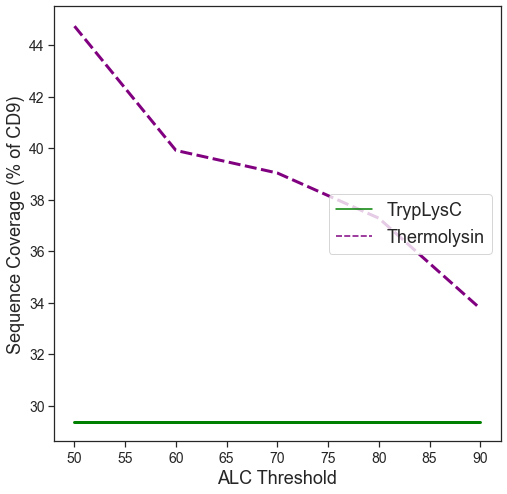

In [135]:
plt.figure(figsize=(8,8))
sns.set_style("ticks")
sns.lineplot(x="ALC", y="Peptide",linewidth = 3,
             hue="ID", style="ID",
             data=ALC_df,palette=colors)
plt.ylabel("Sequence Coverage (% of CD9)",fontsize=18)
plt.xlabel("ALC Threshold",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18,loc='right')
plt.savefig("ALCvsSC_CD9.eps",dpi=600)

In [136]:
dataframes=[tl_denovo,thermo_denovo]
labels=["TrypLysC","Thermolysin"]
ALC_pep=[]
ALC_label=[]
ALC_hold=[]
for frame,label in zip(dataframes,labels):
        for hold in thresholds:
            check=frame.loc[frame['ALC (%)'] >= hold]
            ALC_pep.append(len(check))
            ALC_label.append(label)
            ALC_hold.append(hold)
ALC_PeptideNumber=pd.DataFrame({"ALC":ALC_hold,
                               "Enzyme":ALC_label,
                               "Peptide_Number":ALC_pep})

In [137]:
ALC_PeptideNumber

,ALC,Enzyme,Peptide_Number
0,50,TrypLysC,82883
1,60,TrypLysC,63988
2,70,TrypLysC,46495
3,80,TrypLysC,30925
4,90,TrypLysC,17408
5,50,Thermolysin,61767
6,60,Thermolysin,39580
7,70,Thermolysin,24075
8,80,Thermolysin,13887
9,90,Thermolysin,7234


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


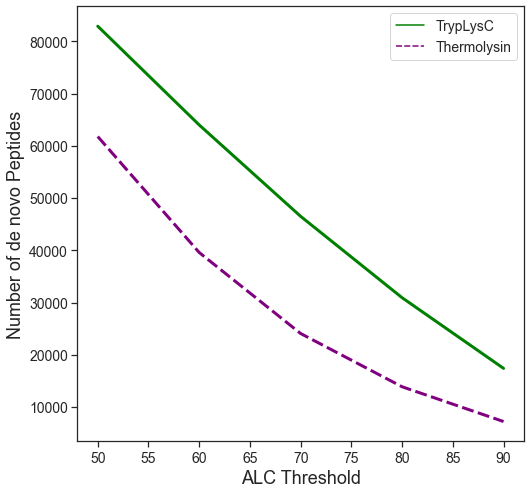

In [138]:
plt.figure(figsize=(8,8))
sns.set_style("ticks")
sns.lineplot(x="ALC", y="Peptide_Number",linewidth = 3,
             hue="Enzyme", style="Enzyme",
             data=ALC_PeptideNumber,palette=colors)
plt.ylabel("Number of de novo Peptides",fontsize=18)
plt.xlabel("ALC Threshold",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig("DeNovo_PeptideNumber.eps",dpi=600)

### De novo Peptide Details

In [139]:
tl_denovo.describe()

,Fraction,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Area,Mass,ppm
count,82883.000000,82883.000000,82883.000000,82883.000000,82883.000000,82883.000000,82883.000000,82883.000000,8.288300e+04,82883.000000,82883.000000
mean,15.721258,13.671079,73.716649,73.716649,13.671079,656.685176,2.364659,41.173590,6.247161e+07,1544.818250,0.328519
std,10.126695,5.364237,15.008179,15.008179,5.364237,185.586806,0.626550,15.667442,4.980115e+08,590.696777,8.026211
min,2.000000,5.000000,50.000000,50.000000,5.000000,399.958900,1.000000,3.540000,0.000000e+00,456.244400,-20.100000
25%,4.000000,10.000000,61.000000,61.000000,10.000000,508.601100,2.000000,30.770000,8.133900e+05,1108.624000,-2.000000
50%,14.000000,13.000000,73.000000,73.000000,13.000000,629.356700,2.000000,39.300000,3.323400e+06,1428.627900,0.200000
75%,21.000000,17.000000,87.000000,87.000000,17.000000,763.395400,3.000000,47.760000,1.232350e+07,1852.865000,3.300000
max,33.000000,45.000000,99.000000,99.000000,45.000000,1492.261200,7.000000,136.270000,2.438800e+10,5557.792000,20.000000


In [140]:
tl_denovo['Match'] = np.where(tl_denovo['Accession'].isnull(), "Unmatched", 'Matched')
thermo_denovo['Match'] = np.where(thermo_denovo['Accession'].isnull(), "Unmatched", 'Matched')
thermo_denovo.head(20)

<ipython-input-140-2f42fea6169e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tl_denovo['Match'] = np.where(tl_denovo['Accession'].isnull(), "Unmatched", 'Matched')
<ipython-input-140-2f42fea6169e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thermo_denovo['Match'] = np.where(thermo_denovo['Accession'].isnull(), "Unmatched", 'Matched')


,Fraction,Source File,Feature,Peptide,Scan,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Predict RT,Area,Mass,ppm,Accession,PTM,local confidence (%),tag (>=0%),mode,Match
0,19,TC_01May2021_OVCAR3_Thermolysin_90min_rep2.raw,F19:83736,FQECCQAEDKGAC,F19:5998,14,99,99,14,851.3374,2,21.69,-,2.372900e+09,1700.6592,0.6,NaN,Carbamidomethylation,100 100 100 100 100 100 100 100 100 100 100 10...,VFQEC(+57.02)C(+57.02)QAEDKGAC(+57.02),HCD,Unmatched
2,11,TC_26April2021_EOC18_Thermolysin_90min.raw,F11:32040,TYDYYKN,F11:6906,8,99,99,8,533.2485,2,25.76,-,4.559000e+08,1064.4814,1.0,NaN,NaN,100 100 100 100 100 100 100 100,VTYDYYKN,HCD,Unmatched
4,9,TC_24April2021_hIOSE_Thermolysin_90min.raw,F9:49672,SVDGL,F9:14385,6,99,99,6,603.3358,1,38.82,-,1.520300e+06,602.3275,1.7,NaN,NaN,100 100 100 100 100 100,LSVDGL,HCD,Unmatched
7,27,TC_26April2021_EOC18_Thermolysin_90min_rep2.raw,F27:34598,TYDYYKN,F27:7604,8,99,99,8,533.2482,2,25.24,-,8.745800e+08,1064.4814,0.3,NaN,NaN,100 100 100 100 100 100 100 100,VTYDYYKN,HCD,Unmatched
9,23,TC_30April2021_hIOSE_Thermolysin_90min_rep2.raw,F23:38116,LASF,F23:15041,5,99,99,5,550.3239,1,40.68,-,2.699700e+06,549.3162,0.6,NaN,NaN,100 100 100 100 100,LLASF,HCD,Unmatched
11,27,TC_26April2021_EOC18_Thermolysin_90min_rep2.raw,F27:44657,YGSF,F27:11411,5,99,99,5,572.2716,1,32.22,-,3.462500e+06,571.2642,0.2,NaN,NaN,100 100 100 100 100,VYGSF,HCD,Unmatched
12,19,TC_01May2021_OVCAR3_Thermolysin_90min_rep2.raw,F19:73026,ELSDY,F19:14244,6,99,99,6,739.3508,1,36.17,-,1.086900e+07,738.3436,0.0,NaN,NaN,100 100 100 100 100 100,LELSDY,HCD,Unmatched
13,19,TC_01May2021_OVCAR3_Thermolysin_90min_rep2.raw,F19:49381,AQCCKLPTT,F19:8434,10,99,99,10,596.7888,2,26.23,-,2.976500e+08,1191.5627,0.3,NaN,Deamidation (NQ); Carbamidomethylation,100 100 100 100 100 100 100 100 100 100,LAQ(+.98)C(+57.02)C(+57.02)KLPTT,HCD,Unmatched
16,3,TC_24April2021_OVCAR3_Thermolysin_90min.raw,F3:57978,TASSF,F3:11425,6,99,99,6,625.3182,1,30.62,-,1.743100e+07,624.3119,-1.5,P02751|FINC_HUMAN:P12259|FA5_HUMAN,NaN,100 100 100 100 100 100,LTASSF,HCD,Matched
17,19,TC_01May2021_OVCAR3_Thermolysin_90min_rep2.raw,F19:76660,TFDDY,F19:16261,6,99,99,6,773.3349,1,39.76,-,3.166400e+06,772.3279,-0.4,P30626|SORCN_HUMAN,NaN,100 100 100 100 100 100,LTFDDY,HCD,Matched


In [141]:
# x=[tl_denovo.loc[:,tl_denovo["Match"]=="Unmatched"],thermo_denovo.loc[:,thermo_denovo["Match"]=="Unmatched"]]
# mustard=pd.concat([i for i in x], axis=1)
# gravy.columns = ["TrypLysC","Thermolysin"]
# sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("ticks")
# meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
# boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
# plt.tick_params(axis='x', colors='black', length=10, width=2)
# plt.tick_params(axis='y', colors='black', length=10, width=2)
# sns.stripplot(data=gravy,palette=colors2,s=1.5)
# sns.boxplot(data=gravy,showmeans=True, meanline=True,
#             boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# # plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.ylabel("Peptide GRAVY Score",fontsize=22)
# plt.xticks(fontsize=14,rotation=90)
# plt.yticks(fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
# plt.savefig('denovo_GRAVY',format=fmt,dpi=dpi,bbox_inches="tight")
# plt.show()

### De Novo Peptide Characteristics

In [142]:
tl_denovo['ID'] = np.resize("TrypLysC",len(tl_denovo))
thermo_denovo['ID'] = np.resize("Thermolysin",len(thermo_denovo))
denovo_mash=pd.concat([tl_denovo,thermo_denovo],ignore_index=True)
denovo_mash["Peptide"]= denovo_mash["Peptide"].str.replace('\W+|\d+',"")
Chef.Marinate(denovo_mash,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True,Peptide_Inspector=False)
denovo_mash.describe()

<ipython-input-142-874031330353>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tl_denovo['ID'] = np.resize("TrypLysC",len(tl_denovo))
<ipython-input-142-874031330353>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thermo_denovo['ID'] = np.resize("Thermolysin",len(thermo_denovo))


Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Fraction,Tag Length,Denovo Score,ALC (%),length,m/z,z,RT,Area,Mass,ppm,IPC,Hydro_Sum,Neutral_Z
count,144650.000000,144650.000000,144650.000000,144650.000000,144650.000000,144650.000000,144650.000000,144650.000000,1.446500e+05,144650.000000,144650.000000,144650.000000,144650.000000,144650.000000
mean,15.395631,11.717940,71.292624,71.292624,11.717940,623.458952,2.110978,38.129514,4.844815e+07,1312.958393,0.656990,5.999002,-0.182871,-0.499516
std,9.977701,5.087296,14.921957,14.921957,5.087296,164.797769,0.667449,13.814312,4.325678e+08,566.145056,8.059311,2.375052,0.849630,1.190288
min,1.000000,5.000000,50.000000,50.000000,5.000000,399.958900,1.000000,3.420000,0.000000e+00,399.211800,-20.100000,2.676475,-3.783333,-9.000000
25%,4.000000,8.000000,58.000000,58.000000,8.000000,496.283800,2.000000,28.990000,5.960800e+05,906.409150,-1.800000,3.998818,-0.728571,-1.000000
50%,14.000000,11.000000,69.000000,69.000000,11.000000,596.255900,2.000000,36.140000,2.712900e+06,1209.592750,0.200000,5.969619,-0.177778,0.000000
75%,23.000000,14.000000,84.000000,84.000000,14.000000,713.363925,2.000000,44.310000,1.002075e+07,1565.823175,3.800000,7.146357,0.341667,0.000000
max,33.000000,45.000000,99.000000,99.000000,45.000000,1492.261200,7.000000,136.270000,2.438800e+10,5557.792000,20.000000,12.807744,4.200000,9.000000


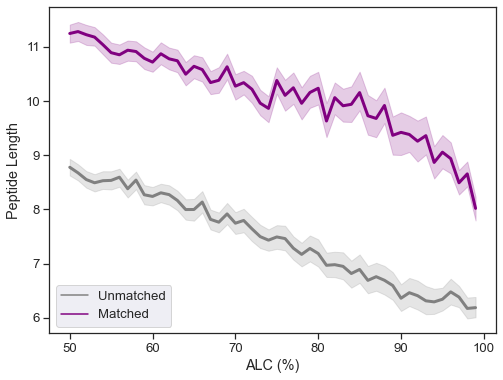

In [143]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
sns.lineplot(data=thermo_denovo, y="length", x="ALC (%)",hue="Match",palette={"Matched":"purple","Unmatched":"grey"},linewidth=3)
ax.legend(loc='lower left')
plt.ylabel("Peptide Length")
plt.savefig("thermo_lengthvsALC_Matched.png",dpi=1200)

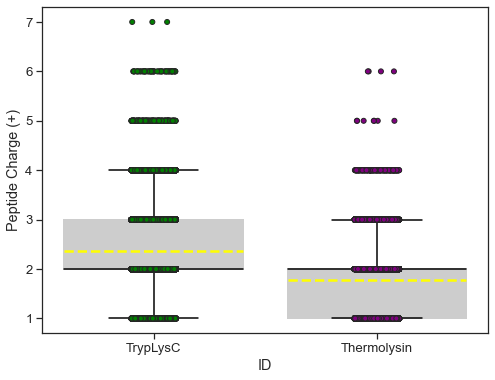

In [144]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
sns.stripplot(data=denovo_mash, y="z", x="ID",palette={"TrypLysC":"green","Thermolysin":"purple"},linewidth=1)
sns.boxplot(data=denovo_mash,y="z", x="ID",showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
plt.ylabel("Peptide Charge (+)")
plt.savefig("denovo_Peptide.eps",dpi=1200)

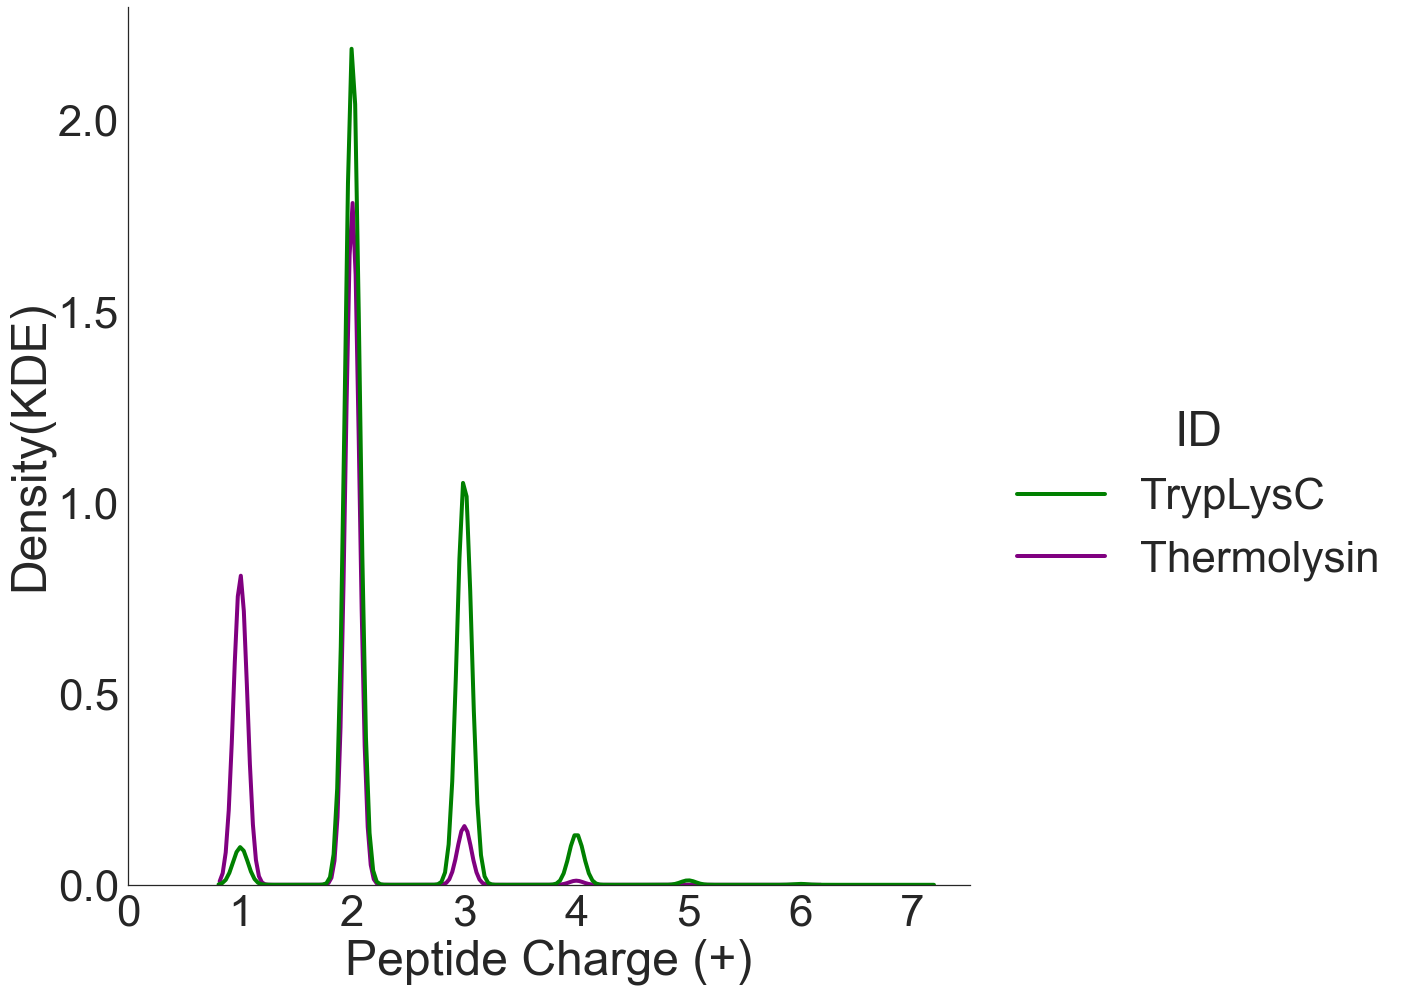

In [145]:
colors = {"TrypLysC":"green","Thermolysin":"purple","Combined":"black"}
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=denovo_mash,
    x="z", hue="ID",palette=colors,
    kind="kde", height=15,log_scale=(0,0),linewidth=4
    
)
plt.xlabel('Peptide Charge (+)', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.xticks(np.arange(0,8,1))
# plt.title('Kernel Density Estimation of Sequence Coverage',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
g.savefig("denovo_Z_KDE.eps",dpi=1200)

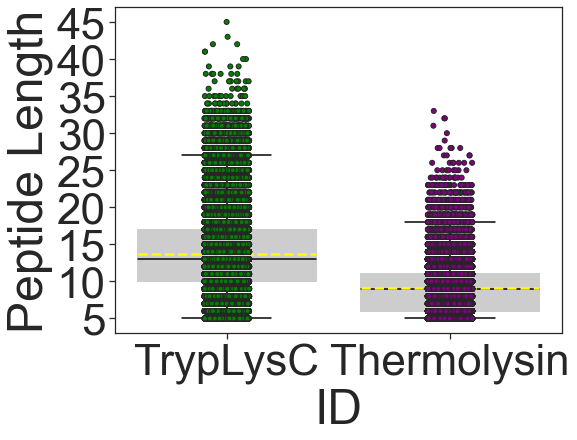

In [146]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
sns.stripplot(data=denovo_mash, y="length", x="ID",palette={"TrypLysC":"green","Thermolysin":"purple"},linewidth=1)
sns.boxplot(data=denovo_mash,y="length", x="ID",showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
plt.ylabel("Peptide Length")
plt.savefig("denovo_Length.eps",dpi=1200)

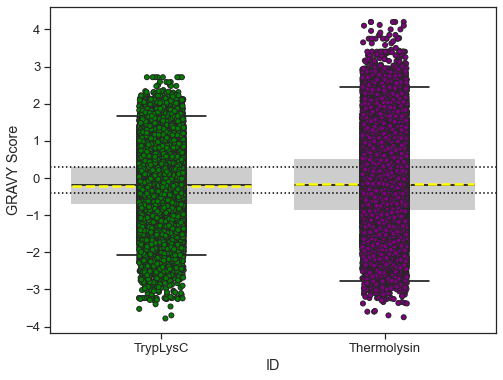

In [147]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
sns.stripplot(data=denovo_mash, y="Hydro_Sum", x="ID",palette={"TrypLysC":"green","Thermolysin":"purple"},linewidth=1)
sns.boxplot(data=denovo_mash,y="Hydro_Sum", x="ID",showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
plt.axhline(y=0.3,color="black",linestyle=":")
plt.axhline(y=-0.4,color="black",linestyle=":")
plt.ylabel("GRAVY Score")
plt.savefig("denovo_GRAVY.eps",dpi=1200)

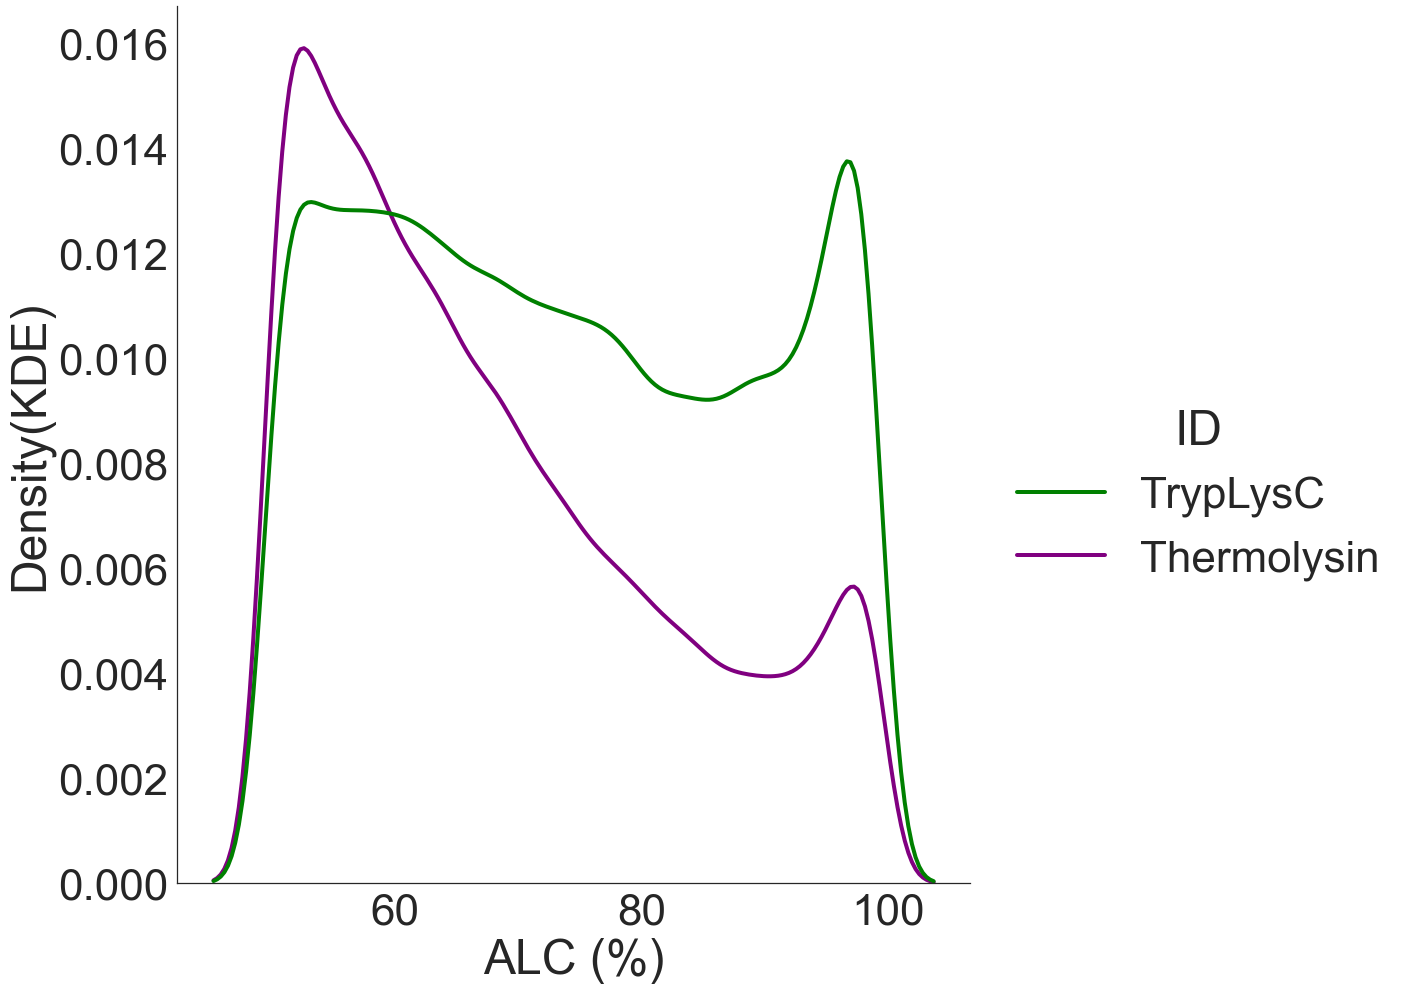

In [148]:
colors = {"TrypLysC":"green","Thermolysin":"purple","Combined":"black"}
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=denovo_mash,
    x="ALC (%)", hue="ID",palette=colors,
    kind="kde", height=15,log_scale=(0,0),linewidth=4
    
)
plt.xlabel('ALC (%)', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
# plt.title('Kernel Density Estimation of Sequence Coverage',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
g.savefig("denovo_ALC_KDE.eps",dpi=1200)

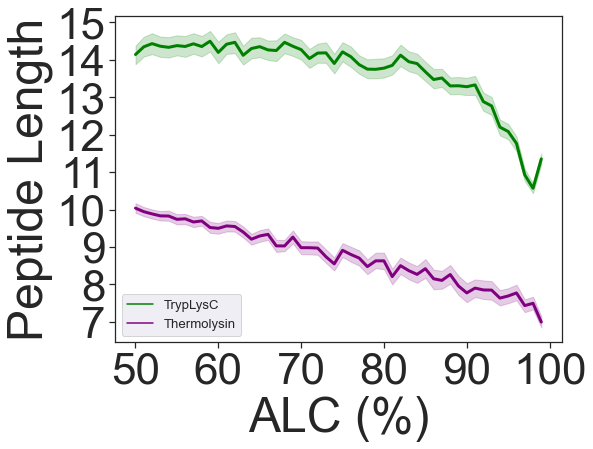

In [149]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
sns.lineplot(data=denovo_mash, y="length", x="ALC (%)", hue="ID",palette={"TrypLysC":"green","Thermolysin":"Purple"},linewidth=3)
ax.legend(loc='lower left')
plt.ylabel("Peptide Length")
plt.savefig("lengthvsALC_Mashed.png",dpi=1200)

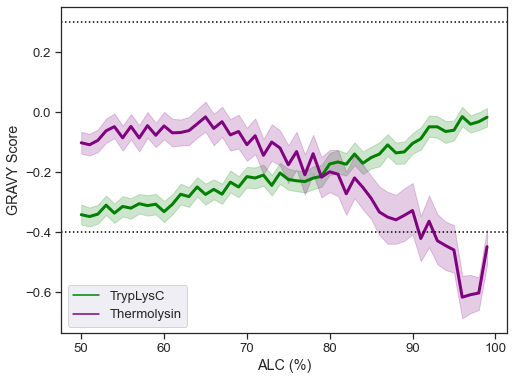

In [150]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
sns.lineplot(data=denovo_mash, y="Hydro_Sum", x="ALC (%)", hue="ID",palette={"TrypLysC":"green","Thermolysin":"Purple"},linewidth=3)
ax.legend(loc='lower left')
plt.ylabel("GRAVY Score")
plt.axhline(y=0.3,color="black",linestyle=":")
plt.axhline(y=-0.4,color="black",linestyle=":")
plt.savefig("GRAVYvsALC_Mashed.png",dpi=1200)

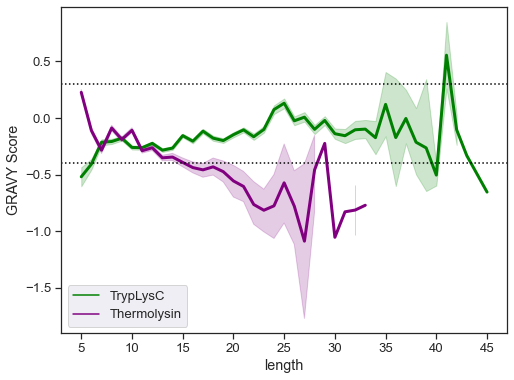

In [151]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
sns.lineplot(data=denovo_mash, y="Hydro_Sum", x="length", hue="ID",palette={"TrypLysC":"green","Thermolysin":"Purple"},linewidth=3)
ax.legend(loc='lower left')
plt.ylabel("GRAVY Score")
plt.axhline(y=0.3,color="black",linestyle=":")
plt.axhline(y=-0.4,color="black",linestyle=":")
plt.savefig("GRAVYvslength_Mashed.png",dpi=1200)

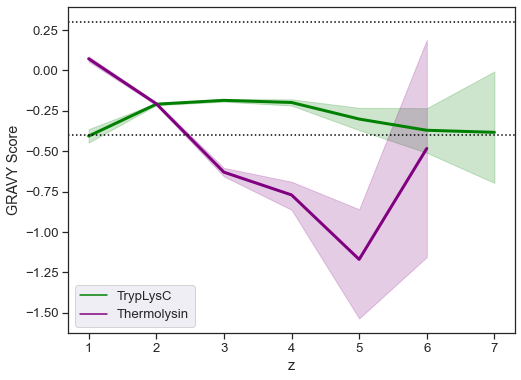

In [152]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
sns.lineplot(data=denovo_mash, y="Hydro_Sum", x="z", hue="ID",palette={"TrypLysC":"green","Thermolysin":"Purple"},linewidth=3)
ax.legend(loc='lower left')
plt.ylabel("GRAVY Score")
plt.axhline(y=0.3,color="black",linestyle=":")
plt.axhline(y=-0.4,color="black",linestyle=":")
plt.savefig("GRAVYvsz_Mashed.png",dpi=1200)

### De novo over time

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


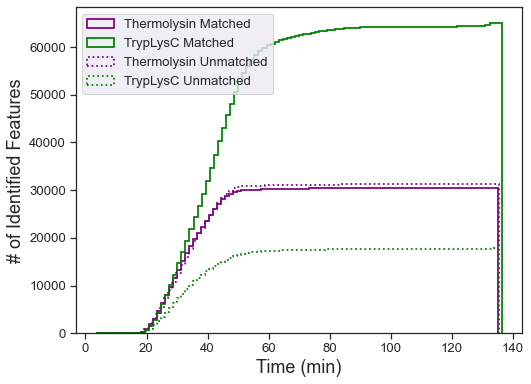

In [153]:
x = thermo_denovo[thermo_denovo['Match'].str.contains("Matched")].RT
y = tl_denovo[tl_denovo['Match'].str.contains("Matched")].RT
z = thermo_denovo[thermo_denovo['Match'].str.contains("Unmatched")].RT
w = tl_denovo[tl_denovo['Match'].str.contains("Unmatched")].RT
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, density=False, histtype='step',
                           cumulative=True, label='Thermolysin Matched',color='purple',linewidth=1.75)

n, bins, patches = ax.hist(y, n_bins, density=False, histtype='step',
                           cumulative=True, label='TrypLysC Matched',color='green',linewidth=1.75)

n, bins, patches = ax.hist(z, n_bins, density=False, histtype='step',
                           cumulative=True, label='Thermolysin Unmatched',color='purple',linestyle=':',linewidth=1.75)

n, bins, patches = ax.hist(w, n_bins, density=False, histtype='step',
                           cumulative=True, label='TrypLysC Unmatched',color='green',linestyle=':',linewidth=1.75)
# tidy up the figure
ax.grid(False)
ax.legend(loc='upper left')
ax.set_xlabel('Time (min)',fontsize=18)
ax.set_ylabel('# of Identified Features',fontsize=18)
plt.savefig("denovo_MatachedFeaturesvsTime.eps",dpi=600)
plt.show()

In [154]:
x = thermo_denovo[thermo_denovo['Match'].str.contains("Matched")]
y = tl_denovo[tl_denovo['Match'].str.contains("Matched")]
z = thermo_denovo[thermo_denovo['Match'].str.contains("Unmatched")]
w = tl_denovo[tl_denovo['Match'].str.contains("Unmatched")]

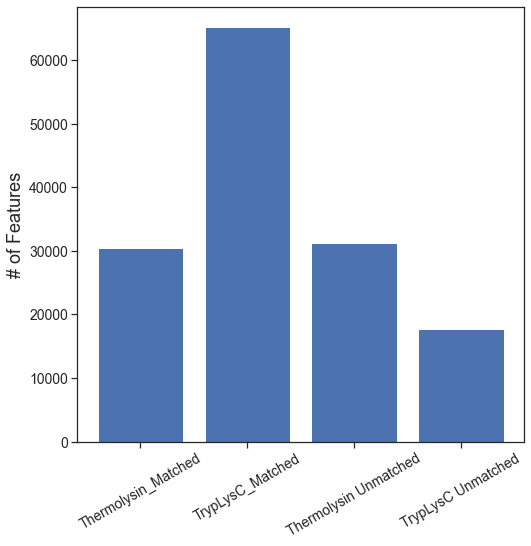

In [155]:
plt.figure(figsize=(8,8))
sns.set_style("ticks")
dataframes=[len(x),len(y),len(z),len(w)]
labels=["Thermolysin_Matched","TrypLysC_Matched","Thermolysin Unmatched","TrypLysC Unmatched"]
plt.bar(labels,dataframes)
plt.ylabel("# of Features",fontsize=18)
plt.xticks(fontsize=14,rotation=30)
plt.yticks(fontsize=14)
plt.savefig("DeNovo_Matched_PeptideNumber.eps",dpi=600,bbox_inches='tight')


### Analysis of Sequence Coverage for all identified Proteins

In [156]:
raw=Chef.PEAKS_Importer("protein-peptides.csv")
rawz =raw.groupby(by="Protein").mean().reset_index()
raws=rawz["Protein"]
len(raws)

3917

In [157]:
Menu_og=pd.read_excel(r'Human_Proteome.xlsx')
Menu_og.drop(Menu_og.columns[0], axis=1, inplace=True)
Menu_og.head()

,Peptide,UniprotID,Gene,Identification,Protein_Length
0,MGCCGCGSCGGCGGGCGGCGGGCGGGCGGGCGSCTTCRCYRVGCCS...,A0A286YF01,SCGR7,HUMAN Small cysteine and glycine repeat-contai...,96
1,MRAKPQSPLPRNPVPAWSPPTTTTDPMLEKDAAGGDFPANLVLQLM...,A1L1A6,IGS23,HUMAN Immunoglobulin superfamily member 23 OS=...,192
2,MVLLAGTRPQGGEARCMIPPPPSPLLGAQVEEDRTEFKEFQDFSSL...,A6NHS1,YK042,HUMAN Putative uncharacterized protein ENSP000...,94
3,MRLCLIPWNTTPHRVLPPVVWSAPSRKKPVLSARNSMMFGHLSPVR...,A6NL46,YF016,HUMAN Putative UPF0607 protein ENSP00000332738...,340
4,MRLCLIPQNTGTPQRVLPPVVWSPPSRKKPMLSACNSMMFGHLSPV...,A8MUI8,YA034,HUMAN Putative UPF0607 protein ENSP00000383783...,341


In [158]:
Menu=Menu_og.loc[Menu_og.UniprotID.isin(raws)].reset_index()
Menu.drop(Menu.columns[0], axis=1, inplace=True)

In [159]:
Menu.head()

,Peptide,UniprotID,Gene,Identification,Protein_Length
0,MANVADTKLYDILGVPPGASENELKKAYRKLAKEYHPDKNPNAGDK...,O60884,DNJA2,HUMAN DnaJ homolog subfamily A member 2 OS=Hom...,412
1,MAEPSAATQSHSISSSSFGAEPSAPGGGGSPGACPALGTKSCSSSC...,O95197,RTN3,HUMAN Reticulon-3 OS=Homo sapiens OX=9606 GN=R...,1032
2,MSETSRTAFGGRRAVPPNNSNAAEDDLPTVELQGVVPRGVNLQEFL...,P00488,F13A,HUMAN Coagulation factor XIII A chain OS=Homo ...,732
3,MPPSGLRLLLLLLPLLWLLVLTPGRPAAGLSTCKTIDMELVKRKRI...,P01137,TGFB1,HUMAN Transforming growth factor beta-1 propro...,390
4,MAENGDNEKMAALEAKICHQIEYYFGDFNLPRDKFLKEQIKLDEGW...,P05455,LA,HUMAN Lupus La protein OS=Homo sapiens OX=9606...,408


In [160]:
grab=Menu[["Peptide", "UniprotID"]].set_index("UniprotID").to_dict()["Peptide"]

In [161]:
#### TrypLysC

In [162]:
# a_label=[]
# b_label=[]
# c_label=[]
# d_label=[]
# grass=thermo_denovo.loc[thermo_denovo['ALC (%)'] >= 80, 'Peptide']
# temp=tuple(set(grass)|set(raw.Peptide))
# i=0
# for gene, peptide in grab.items():
#     x=Chef.Pep2Pro(peptide,temp)
#     sc=x*100
#     a_label.append(gene)
#     b_label.append(sc)
#     c_label.append("Thermolysin_Max")
#     d_label.append(80)
#     print(i)
#     i+=1
# thermo_ninja_max=pd.DataFrame({"Gene":a_label,"Sequence_Coverage":b_label,"Enzyme":c_label,"ALC":d_label})                
# thermo_ninja_max.head()

In [169]:
a_label=[]
b_label=[]
c_label=[]
d_label=[]
grass=tl_denovo.loc[tl_denovo['ALC (%)'] >= 80, 'Peptide']
temp=tuple(set(grass)|set(raw.Peptide))
i=0
for gene, peptide in grab.items():
    x=Chef.Pep2Pro(peptide,temp)
    sc=x*100
    a_label.append(gene)
    b_label.append(sc)
    c_label.append("TrypLys_Max")
    d_label.append(80)
    print(i)
    i+=1
tl_ninja_max=pd.DataFrame({"Gene":a_label,"Sequence_Coverage":b_label,"Enzyme":c_label,"ALC":d_label})                
tl_ninja_max.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


KeyboardInterrupt: 

In [164]:
# tl_ninja_max.to_excel('Tryspin_Grease.xlsx')

NameError: name 'tl_ninja_max' is not defined

In [ ]:
# thermo_ninja.to_excel('Thermolysin_Grease_Max.xlsx')

In [ ]:
tl_ninja=pd.read_excel(r'Tryspin_Grease.xlsx')
thermo_ninja=pd.read_excel(r'Thermolysin_Grease.xlsx')
test=pd.concat([tl_ninja,thermo_ninja],ignore_index=True)

In [ ]:
test2=pd.concat([tl_ninja_max,thermo_ninja_max],ignore_index=True)
test2['Enzyme'] = test2['Enzyme'].replace(['TrypLys_Max'],'TrypLysC_Max')

In [ ]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
sns.stripplot(data=test, y="Sequence_Coverage", x="Enzyme",palette={"TrypLysC":"green","Thermolysin":"purple"},linewidth=1)
sns.boxplot(data=test,y="Sequence_Coverage", x="Enzyme",showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
plt.ylabel("% of Sequence Coverage")
plt.savefig("denovo_sc.eps",dpi=1200)

In [ ]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale = 1.2)
sns.stripplot(data=test2, y="Sequence_Coverage", x="Enzyme",palette={"TrypLysC_Max":"green","Thermolysin_Max":"purple"},linewidth=1)
sns.boxplot(data=test2,y="Sequence_Coverage", x="Enzyme",showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
plt.ylabel("% of Sequence Coverage (Max)")
plt.savefig("denovo_sc_max.eps",dpi=1200)

In [ ]:
# dataframes=[tl_denovo,thermo_denovo]
# labels=["TrypLysC","Thermolysin"]
# thresholds=[50,60,70,80,90]
# temp_list=[]
# test=pd.DataFrame()
# for frame,label in zip(dataframes,labels):
#     for hold in thresholds:
#         a_label=f"{label}{hold}_gene"
#         b_label=f"{label}{hold}_sc"
#         c_label=f"{label}{hold}_enzyme"
#         d_label=f"{label}{hold}_ALC"
#         globals()[str(a_label)]=[]
#         globals()[str(b_label)]=[]
#         globals()[str(c_label)]=[]
#         globals()[str(d_label)]=[]
#         grass=frame.loc[frame['ALC (%)'] >= hold, 'Peptide']
#         temp=tuple(grass)
#         for gene, peptide in raw.items():
#             x=Chef.Pep2Pro(peptide,temp)
#             sc=x*100
#             globals()[str(a_label)].append(gene)
#             globals()[str(b_label)].append(sc)
#             globals()[str(c_label)].append(label)
#             globals()[str(d_label)].append(hold)
#         globals()[str(f"{label}_{hold}")]=pd.DataFrame({"Gene":globals()[str(a_label)],"Sequence_Coverage":globals()[str(b_label)],"Enzyme":globals()[str(c_label)],"ALC":globals()[str(d_label)]})                
#         temp_list.append( globals()[str(f"{label}_{hold}")])
#         print("Yum")
# print("Yummy")
# test=pd.concat(temp_list,ignore_index=True)